In [1]:
import numpy as np
import pandas as pd
from astropy.cosmology import Planck13 as cosmo
from astropy.io import fits
import fsps
from matplotlib.gridspec import GridSpec
from spec_tools import Source_present, Scale_model, Oldest_galaxy, Sig_int,Likelihood_contours, Median_w_Error_cont
from spec_exam import Gen_spec
from sim_engine import *
from spec_stats import Highest_density_region
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from C_full_fit import Gen_spec2, Chi_Squared
from C_sim_test import Gen_sim, F_lam_per_M

import dynesty
from dynesty import plotting as dyplot
from dynesty.utils import quantile as _quantile
from scipy.ndimage import gaussian_filter as norm_kde

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [19]:
sim1 = Gen_spec('GND', 21156, 1.25257,
               g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = True,
            phot_errterm = 0.0, decontam = False) 

sim2 = Gen_spec('GND', 21156, 1.25257,
               g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = False,
            phot_errterm = 0.0, decontam = False) 

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


In [8]:
specz = 1.25

In [4]:
u = 0.0
lbt = []
for i in range(10):
    u+=0.1 * i
    lbt.append(np.round(u,1))
print(lbt)
print(np.round(u + 0.1 * (i+1),1))

[0.0, 0.1, 0.3, 0.6, 1.0, 1.5, 2.1, 2.8, 3.6, 4.5]
5.5


In [5]:
def Time_bins(agelim, bins):
    u = 0.0
    lbt = []
    for i in range(bins):
        u+=0.1 * i
        lbt.append(np.round(u,1))
    
    return np.array(agelim  - lbt / np.round(u + 0.1 * (i+1),1) * agelim)[::-1]

LBT = Time_bins(Oldest_galaxy(1.25),10)
print(LBT)

[0.90396774 1.7175387  2.44071289 3.0734903  3.61587094 4.06785481
 4.4294419  4.70063222 4.88142577 4.97182254]


In [6]:
LBT

array([0.90396774, 1.7175387 , 2.44071289, 3.0734903 , 3.61587094,
       4.06785481, 4.4294419 , 4.70063222, 4.88142577, 4.97182254])

In [7]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 3, sfh = 3, dust_type = 1)
sp.params['dust2'] =0.2
sp.params['dust1'] =0.2

tab_sfh = np.array([0.7, 0.8, 0.5, 0.01, 0.01, 0.001, 0.00001, 0.0002, 0.002, 0.0001])
tab_Z = np.array([0.2, 0.8, 1.0, 1.0, 0.8, 1.1, 0.7, 0.8, 0.8, 0.8])*0.019


sp.set_tabular_sfh(LBT,tab_sfh,
                   Z = tab_Z )

wave1, flux1 = sp.get_spectrum(tage = 3.5, peraa = True)

mass_perc1 = sp.stellar_mass


In [8]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 4, tau=0.1, dust_type = 1)
sp.params['dust2'] =0.2
sp.params['dust1'] =0.2
sp.params['tau'] =0.3
sp.params['logzsol'] = np.log10(0.8)

wave2, flux2 = sp.get_spectrum(tage = 3.5, peraa = True)

mass_perc2 = sp.stellar_mass

In [9]:
def get_50(LBT, md,age):
    hrtime = np.round(np.arange(0,LBT[-1],0.001),2)
    dt = 0.001   
    mass = np.zeros(len(hrtime))
    mbu = 0
    u = 0
    for i in range(len(hrtime)):
        if hrtime[i] > LBT[u]:
            u+=1
        mass[i] = mbu
        mbu += md[u] * dt

    mass = mass[hrtime < age]
    hrtime = hrtime[hrtime < age]
    print(mass[-1])

    return interp1d(mass,hrtime)(0.5), hrtime, mass

In [13]:
get_50(LBT, tab_sfh, Oldest_galaxy(specz) -0.1)

1.6594356099999374


(array(0.71285714),
 array([0.  , 0.  , 0.  , ..., 4.87, 4.87, 4.87]),
 array([0.00000000e+00, 7.00000000e-04, 1.40000000e-03, ...,
        1.65943161e+00, 1.65943361e+00, 1.65943561e+00]))

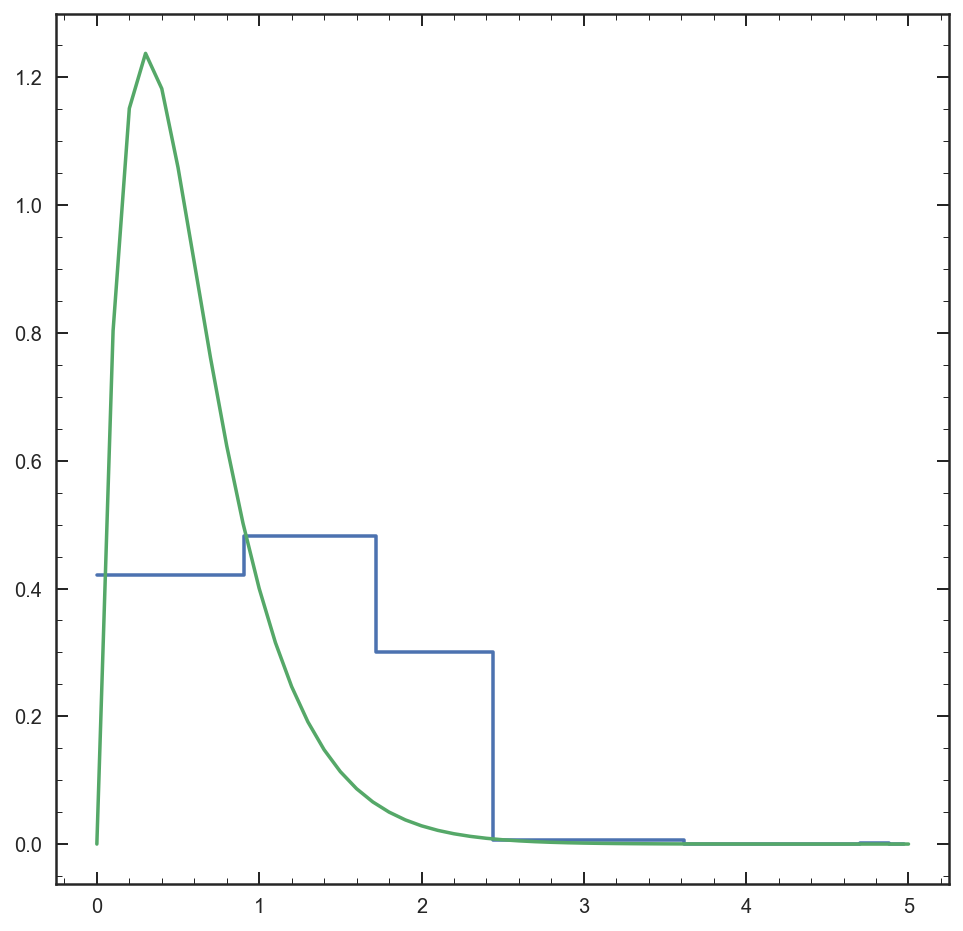

In [13]:
t= np.arange(0,Oldest_galaxy(1.25)+.1,.1)

sfh = t * np.exp(-t / 0.3)

sfh /= np.trapz(sfh,t)
tabsfh = tab_sfh / 1.6594356099999374

plt.figure(figsize=[8,8])
plt.step(np.append(0,LBT), np.append(tabsfh[0], tabsfh))

plt.plot(t,sfh)


In [10]:
D_l = cosmo.luminosity_distance(specz).value # in Mpc
conv = 3.086E24
lsol_to_fsol = 3.839E33

mass_transform = (10**11 / mass_perc1) * lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)



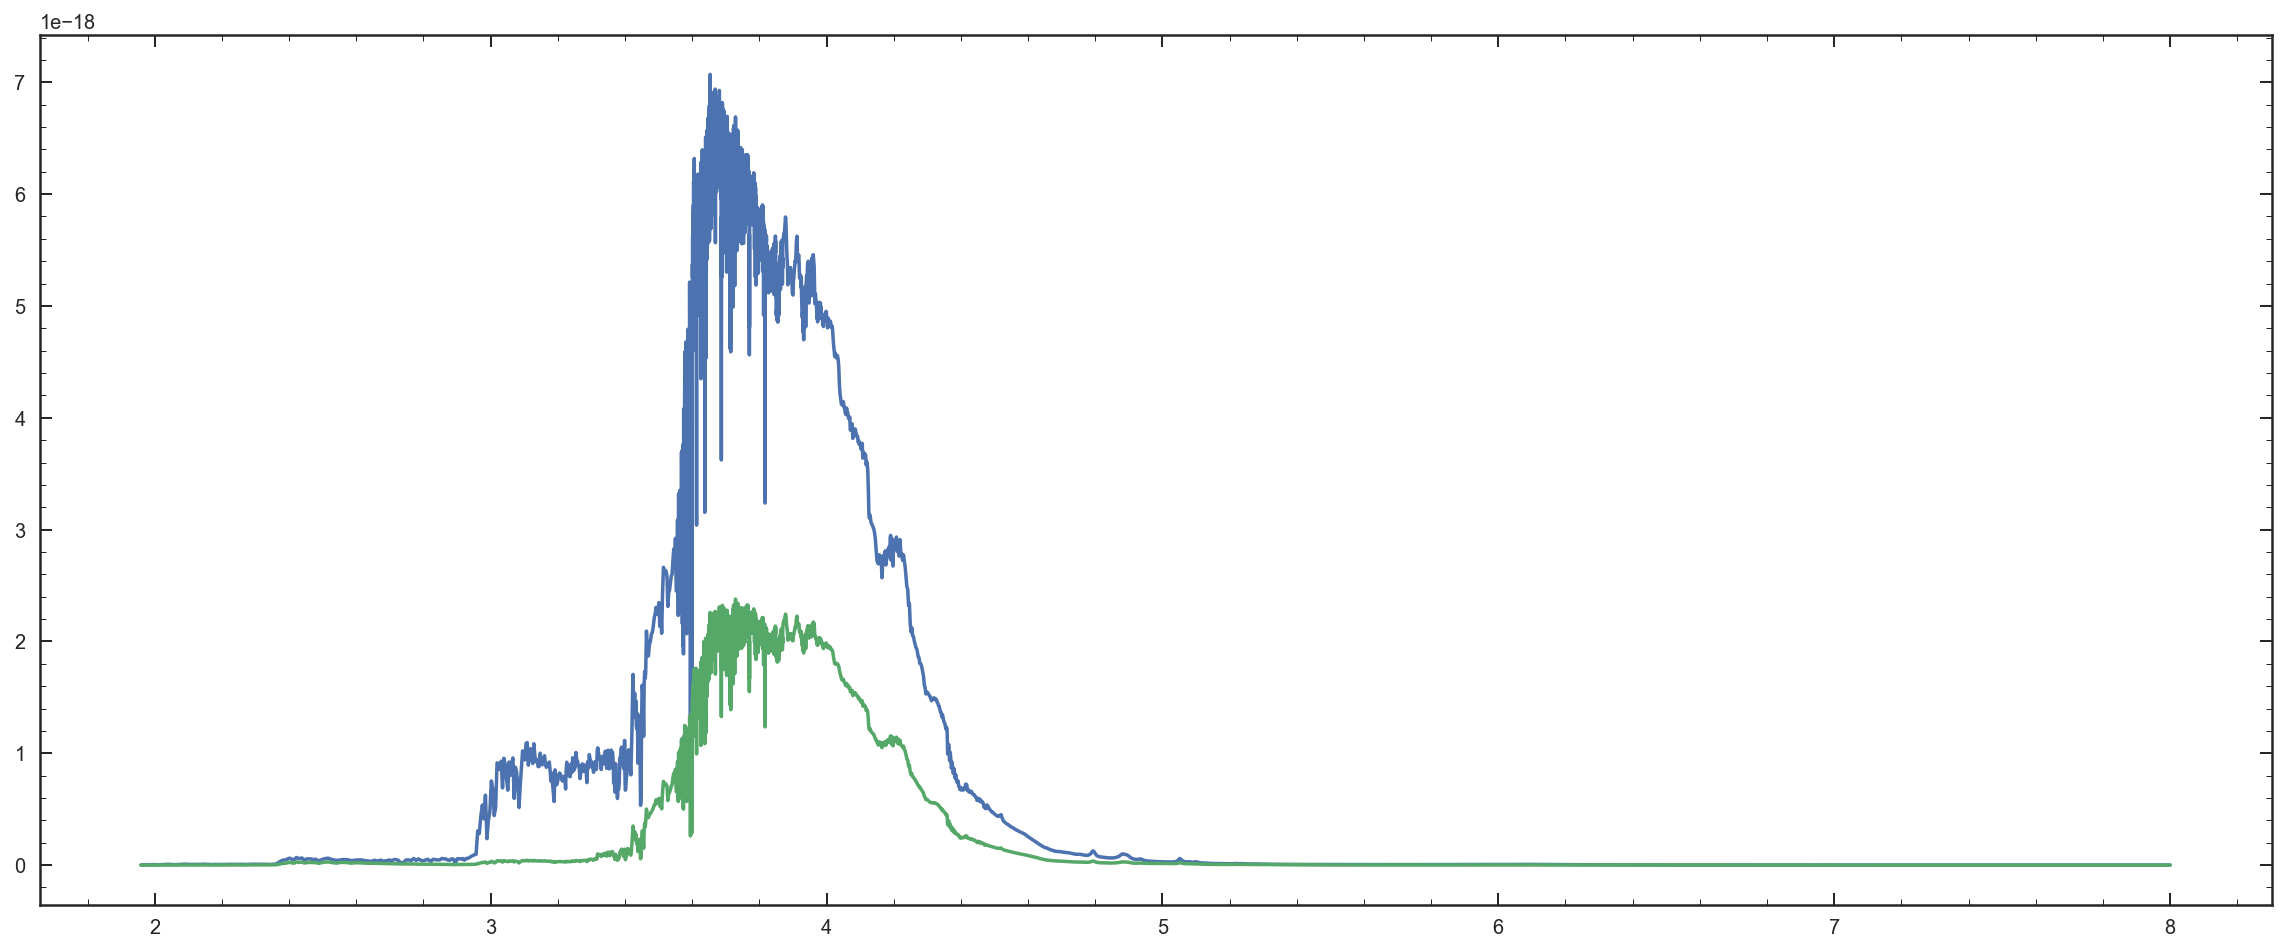

In [11]:
plt.figure(figsize=[20,8])

plt.plot(np.log10(wave1), flux1 * mass_transform)
plt.plot(np.log10(wave2), flux2 * 10**11* lsol_to_fsol / (4 * np.pi * (D_l*conv)**2))

# plt.xlim(np.log10(3000),np.log10(8000))

In [20]:
sim1.Make_sim(wave1, flux1 * mass_transform, specz)
sim2.Make_sim(wave2, flux2 * 10**11* lsol_to_fsol / (4 * np.pi * (D_l*conv)**2), specz, perturb = False)

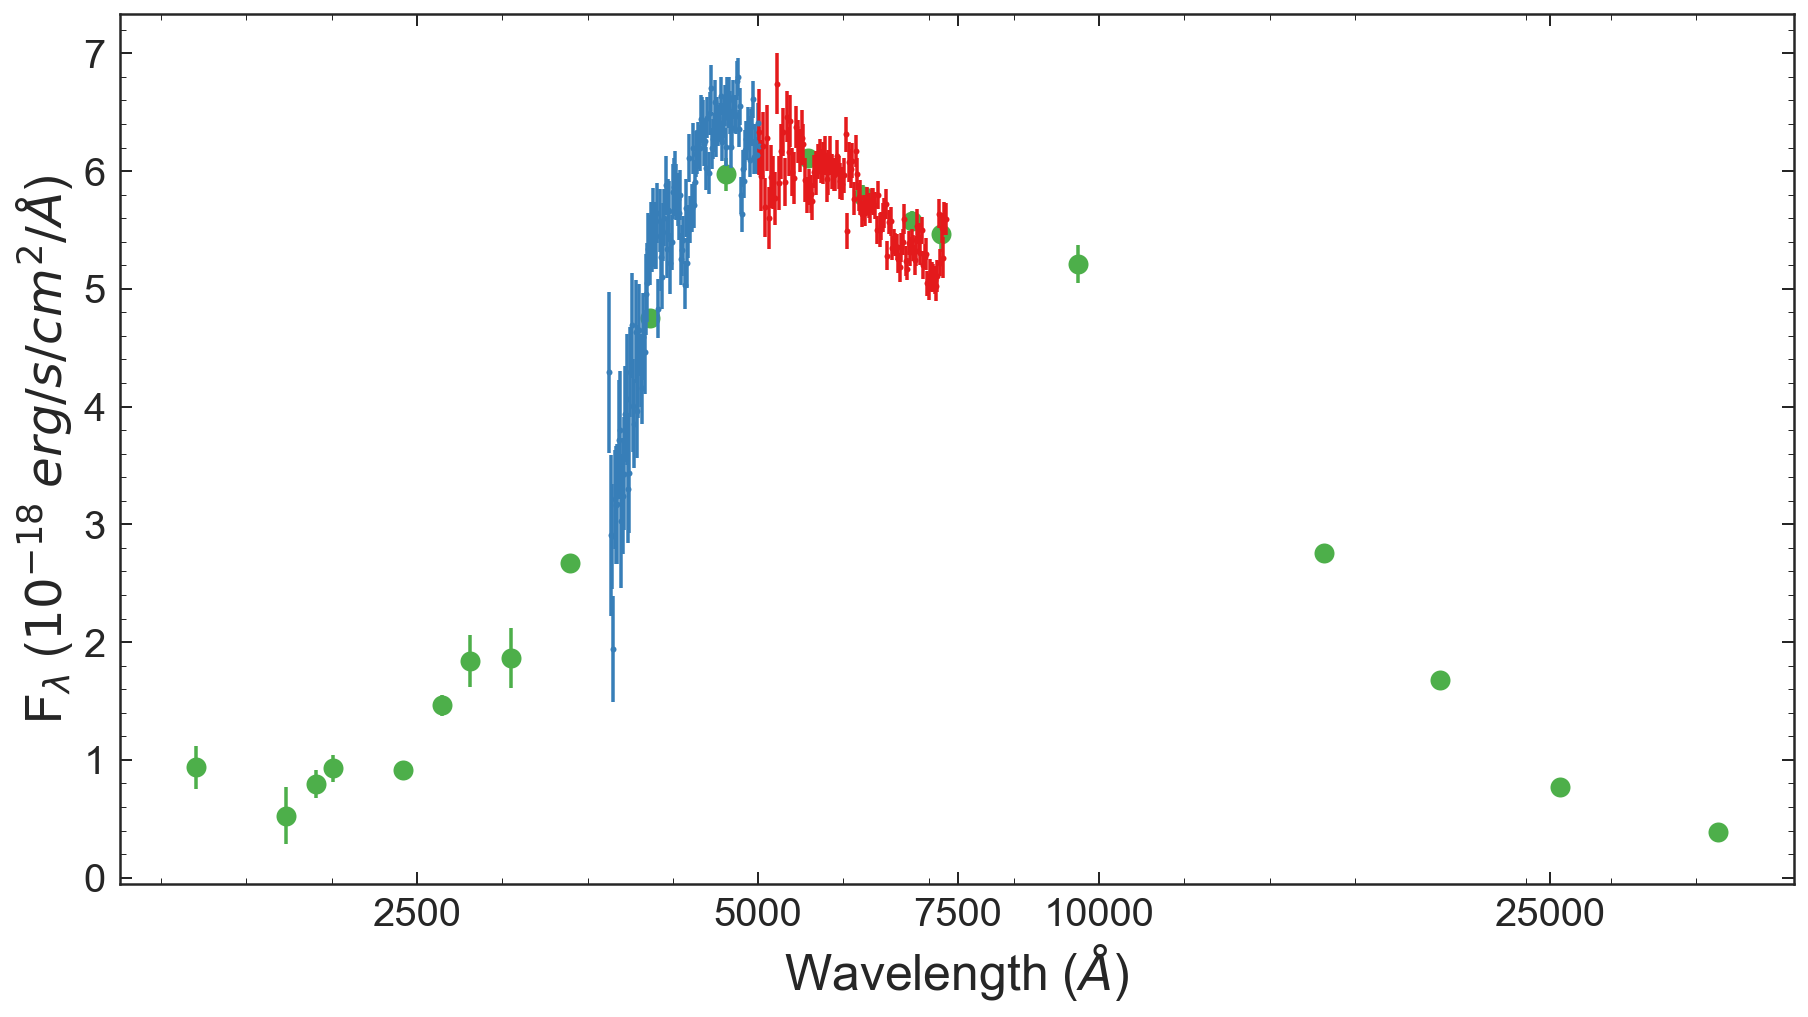

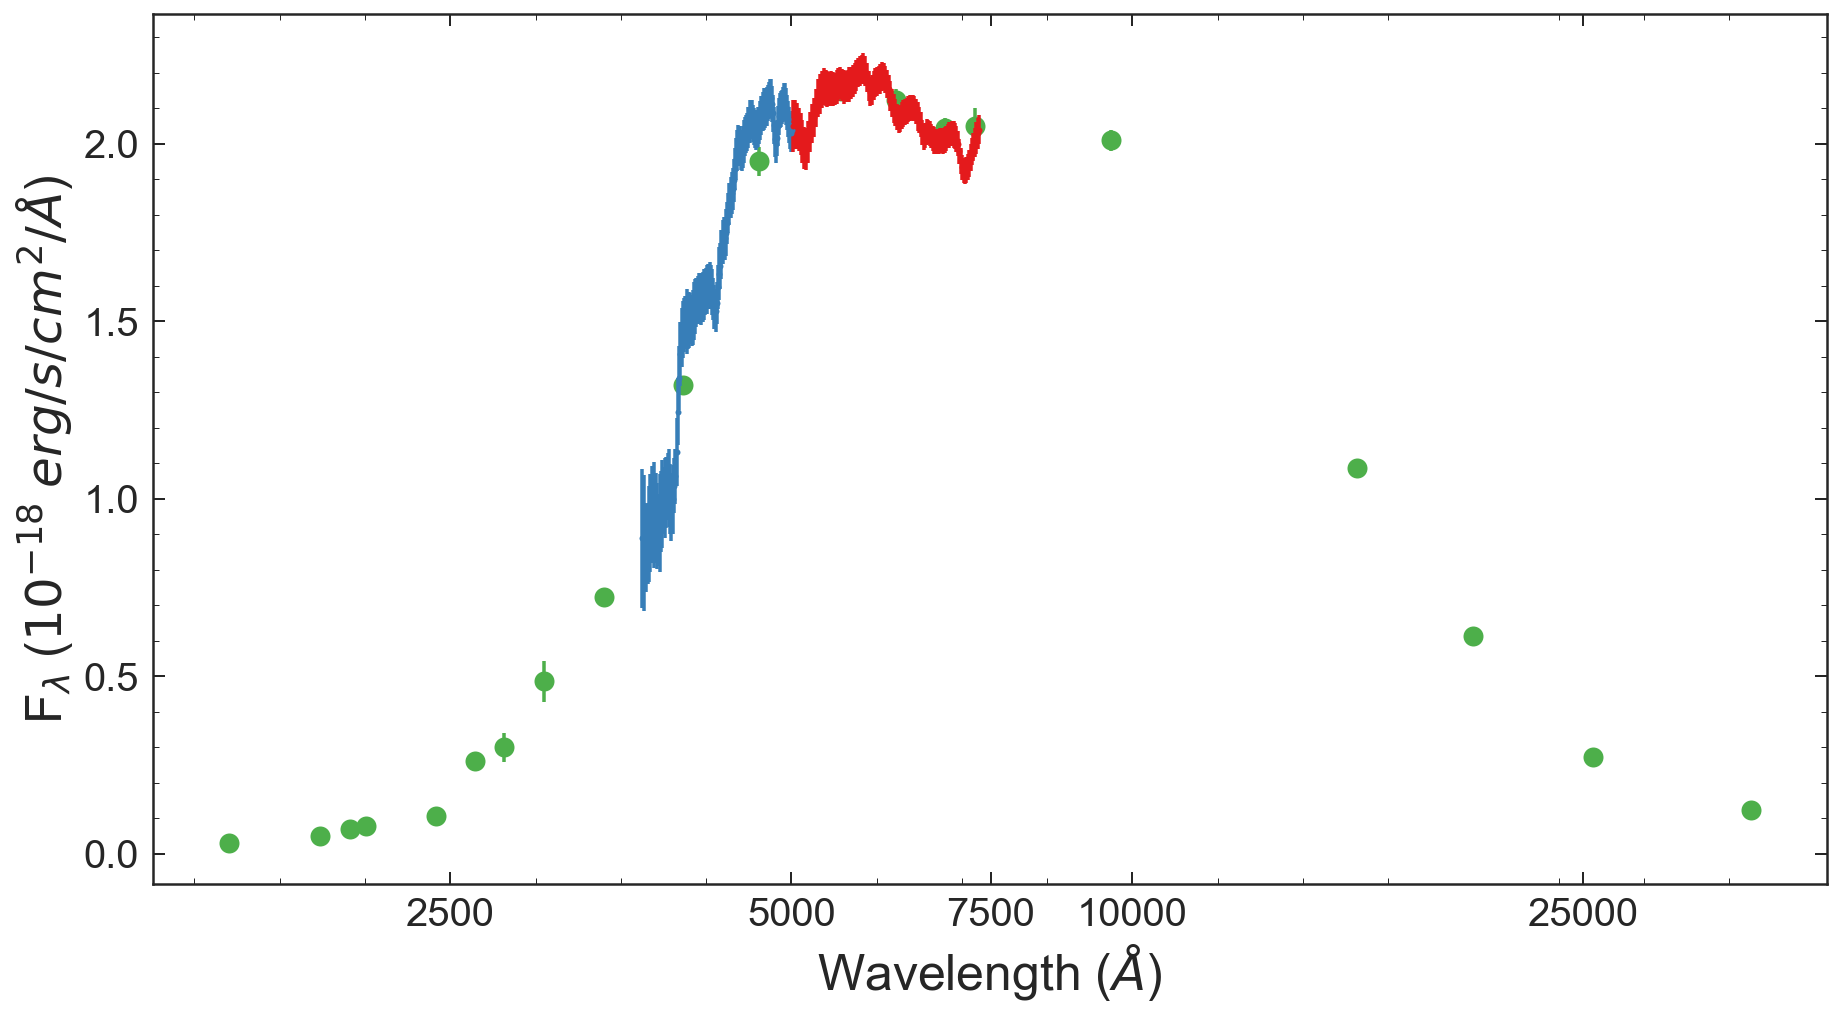

In [21]:
plt.figure(figsize = [15,8])
plt.errorbar(np.log10(sim1.Bwv_rf),sim1.SBfl*1E18,sim1.SBer*1E18,
                linestyle='None', marker='o', markersize=3, color='#377eb8',zorder = 2, label = 'CLEAR G102')
plt.errorbar(np.log10(sim1.Rwv_rf),sim1.SRfl*1E18,sim1.SRer*1E18,
                linestyle='None', marker='o', markersize=3, color='#e41a1c',zorder = 2, label = '3D-HST G141')
plt.errorbar(np.log10(sim1.Pwv_rf),sim1.SPflx*1E18,sim1.SPerr*1E18,
                                 linestyle='None', marker='o', markersize=10, color='#4daf4a',zorder = 1, label = '3D-HST Photometry')

plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])

plt.xlabel('Wavelength ($\AA$)', fontsize=25)
plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.figure(figsize = [15,8])
plt.errorbar(np.log10(sim2.Bwv_rf),sim2.SBfl*1E18,sim2.SBer*1E18,
                linestyle='None', marker='o', markersize=3, color='#377eb8',zorder = 2, label = 'CLEAR G102')
plt.errorbar(np.log10(sim2.Rwv_rf),sim2.SRfl*1E18,sim2.SRer*1E18,
                linestyle='None', marker='o', markersize=3, color='#e41a1c',zorder = 2, label = '3D-HST G141')
plt.errorbar(np.log10(sim2.Pwv_rf),sim2.SPflx*1E18,sim2.SPerr*1E18,
                                 linestyle='None', marker='o', markersize=10, color='#4daf4a',zorder = 1, label = '3D-HST Photometry')

plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])

plt.xlabel('Wavelength ($\AA$)', fontsize=25)
plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)

# Define Priors

In [23]:
agelim = Oldest_galaxy(specz)

def delay_prior(u):
    m = (0.03 * u[0] + 0.001) / 0.019
    a = (agelim - 0.01)* u[1] + 0.01
    t = (1.5 - 0.001)*u[2] + 0.001  
    z = specz + 0.002*(2*u[3] - 1)
    d = 1*u[4]
    lm = 11.0 + 1.25*(2*u[5] - 1)

    return [m, a, t, z, d, lm]

def tab_prior(u):
    m1 = (0.03 * u[0] + 0.001) / 0.019
    m2 = (0.03 * u[1] + 0.001) / 0.019
    m3 = (0.03 * u[2] + 0.001) / 0.019
    m4 = (0.03 * u[3] + 0.001) / 0.019
    m5 = (0.03 * u[4] + 0.001) / 0.019
    m6 = (0.03 * u[5] + 0.001) / 0.019
    m7 = (0.03 * u[6] + 0.001) / 0.019
    m8 = (0.03 * u[7] + 0.001) / 0.019
    m9 = (0.03 * u[8] + 0.001) / 0.019
    m10 = (0.03 * u[9] + 0.001) / 0.019
    
    a = (agelim - 0.01)* u[10] + 0.01
    
    t1 = u[11]
    t2 = u[12]
    t3 = u[13]
    t4 = u[14]
    t5 = u[15]  
    t6 = u[16]
    t7 = u[17]
    t8 = u[18]
    t9 = u[19]
    t10 = u[20] 
    
    d = 1*u[21]
    
    lm = 11.0 + 1.25*(2*u[22] - 1)
    
    return [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, a, t1, t2, t3, t4, t5, t6, t7, t8, t9, t10, d, lm]

## Define Likelihoods

In [26]:
def forward_model_all_beams(beams, trans, in_wv, model_wave, model_flux):
    FL = np.zeros([len(beams),len(in_wv)])

    for i in range(len(beams)):
        mwv, mflx = forward_model_grism(beams[i], model_wave, model_flux)
        FL[i] = interp1d(mwv, mflx)(in_wv)
        FL[i] /= trans[i]

    return np.mean(FL.T,axis=1)

def Gather_grism_sim_data(spec):
    wvs = []
    flxs = []
    errs = []
    beams = []
    trans = []
    
    if spec.g102:
        wvs.append(spec.Bwv)
        flxs.append(spec.SBfl)
        errs.append(spec.SBer)
        beams.append(spec.Bbeam)
        trans.append(spec.Btrans)
    
    if spec.g141:
        wvs.append(spec.Rwv)
        flxs.append(spec.SRfl)
        errs.append(spec.SRer)
        beams.append(spec.Rbeam)
        trans.append(spec.Rtrans)

    return np.array([wvs, flxs, errs, beams, trans])

def Full_forward_model(spec, wave, flux, specz):
    Gmfl = []
    
    for i in range(len(wvs)):
        Gmfl.append(forward_model_all_beams(beams[i], trans[i], wvs[i], wave * (1 + specz), flux))

    Pmfl = spec.Sim_phot_mult(wave * (1 + specz),flux)

    return np.array(Gmfl), Pmfl


def Full_fit(spec, Gmfl, Pmfl):
    Gchi = 0
    
    for i in range(len(wvs)):
        scale = Scale_model(flxs[i], errs[i], Gmfl[i])
        Gchi = Gchi + np.sum(((((flxs[i] / scale) - Gmfl[i]) / (errs[i] / scale))**2))
    
    Pchi = np.sum((((spec.Pflx - Pmfl) / spec.Perr)**2))
    
    return Gchi, Pchi


conv = 3.086E24 # Mpc to cm
lsol_to_fsol = 3.839E33 # change L_/odot to F_/odot

def delay_L(X):
    m, a, t, z, d, lm = X
    
    sp.params['logzsol'] = np.log10( m )
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    sp.params['tau'] = t

    wave, flux = sp.get_spectrum(tage = a, peraa = True)
    
    D_l = cosmo.luminosity_distance(z).value # in Mpc

    mass_transform = (10**lm * lsol_to_fsol) / (4 * np.pi * (D_l*conv)**2)
    
    Gmfl, Pmfl = Full_forward_model(sim1, wave, flux * mass_transform, z)
    
    Gchi, Pchi = Full_fit(sim1, Gmfl, Pmfl)
                  
    return -0.5 * (Gchi + Pchi)

def tab_L(X):
    m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, a, t1, t2, t3, t4, t5, t6, t7, t8, t9, t10, d, lm = X
    
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    
    sp.set_tabular_sfh(LBT,np.array([t1, t2, t3, t4, t5, t6, t7, t8, t9, t10]),
                      Z = np.array([m1, m2, m3, m4, m5, m6, m7, m8, m9, m10]) * 0.019)
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)
    
    D_l = cosmo.luminosity_distance(z).value # in Mpc

    mass_transform = (10**lm / sp.stellar_mass) * lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)  
    
    Gmfl, Pmfl = Full_forward_model(Gs, wave, flux * mass_transform, z)
    
    Gchi, Pchi = Full_fit(Gs, Gmfl, Pmfl)
                  
    return -0.5 * (Gchi + Pchi)



## Setup for tab fit delay

In [33]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 4, tau=0.1, dust_type = 1)

agelim = Oldest_galaxy(specz)

def delay_prior(u):
    m = (0.03 * u[0] + 0.001) / 0.019
    a = (agelim - 0.01)* u[1] + 0.01
    t = (1.5 - 0.001)*u[2] + 0.001  
    z = specz + 0.002*(2*u[3] - 1)
    d = 1*u[4]
    lm = 11.0 + 1.25*(2*u[5] - 1)

    return [m, a, t, z, d, lm]

def forward_model_all_beams(beams, trans, in_wv, model_wave, model_flux):
    FL = np.zeros([len(beams),len(in_wv)])

    for i in range(len(beams)):
        mwv, mflx = forward_model_grism(beams[i], model_wave, model_flux)
        FL[i] = interp1d(mwv, mflx)(in_wv)
        FL[i] /= trans[i]

    return np.mean(FL.T,axis=1)

def Full_forward_model(spec, wave, flux, specz):
    Gmfl = []
    
    for i in range(len(wvs1)):
        Gmfl.append(forward_model_all_beams(beams1[i], trans1[i], wvs1[i], wave * (1 + specz), flux))

    Pmfl = spec.Sim_phot_mult(wave * (1 + specz),flux)

    return np.array(Gmfl), Pmfl


def Full_fit(spec, Gmfl, Pmfl):
    Gchi = 0
    
    for i in range(len(wvs1)):
        scale = Scale_model(flxs1[i], errs1[i], Gmfl[i])
        Gchi = Gchi + np.sum(((((flxs1[i] / scale) - Gmfl[i]) / (errs1[i] / scale))**2))
    
    Pchi = np.sum((((spec.SPflx - Pmfl) / spec.SPerr)**2))
    
    return Gchi, Pchi

wvs1, flxs1, errs1, beams1, trans1 = Gather_grism_sim_data(sim1)

def delay_L(X):
    m, a, t, z, d, lm = X
    
    sp.params['logzsol'] = np.log10( m )
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    sp.params['tau'] = t

    wave, flux = sp.get_spectrum(tage = a, peraa = True)
    
    D_l = cosmo.luminosity_distance(z).value # in Mpc

    mass_transform = (10**lm * lsol_to_fsol) / (4 * np.pi * (D_l*conv)**2)
    
    Gmfl, Pmfl = Full_forward_model(sim1, wave, flux * mass_transform, z)
    
    Gchi, Pchi = Full_fit(sim1, Gmfl, Pmfl)
                  
    return -0.5 * (Gchi + Pchi)

In [34]:
t_dsampler = dynesty.NestedSampler(delay_L, delay_prior, ndim = 6, sample = 'rwalk', bound = 'balls') 

In [35]:
t_dsampler.run_nested(print_progress=True)


iter: 4665 | bound: 183 | nc: 25 | ncall: 90465 | eff(%):  5.157 | loglstar:   -inf < -266.022 <    inf | logz: -279.386 +/-  0.157 | dlogz: 113.302 >  0.509            

Exception while calling loglikelihood function:
  params: [ 0.23397489  2.25018585  0.32121339  1.25166318  0.49807807 11.19473439]
  args: {}
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/dynesty.py", line 560, in __call__
    return self.func(x, *self.args, **self.kwargs)
  File "<ipython-input-33-d0e269dd6209>", line 63, in delay_L
    Gmfl, Pmfl = Full_forward_model(sim1, wave, flux * mass_transform, z)
  File "<ipython-input-33-d0e269dd6209>", line 29, in Full_forward_model
    Gmfl.append(forward_model_all_beams(beams1[i], trans1[i], wvs1[i], wave * (1 + specz), flux))
  File "<ipython-input-33-d0e269dd6209>", line 19, in forward_model_all_beams
    mwv, mflx = forward_model_grism(beams[i], model_wave, model_flux)
  File "/Users/vestrada/Github/Cluster_and_field/scripts/sim_engine.py", line 201, in forward_model_grism
    BEAM.beam.compute_model(spectrum_1d=[model_wave, model_flux])
  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py", line 524, in co

KeyboardInterrupt: 

## Setup for delay fit tab

In [89]:
def Time_bins(agelim, bins):
    u = 0.0
    lbt = []
    for i in range(bins):
        u+=0.1 * i
        lbt.append(np.round(u,1))
    
    return np.array(agelim  - lbt / np.round(u + 0.1 * (i+1),1) * agelim)[::-1]

LBT = Time_bins(Oldest_galaxy(1.25),10)

sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 3, sfh = 3, dust_type = 1)

def tab_prior(u):
    m1 = (0.03 * u[0] + 0.001) / 0.019
    m2 = (0.03 * u[1] + 0.001) / 0.019
    m3 = (0.03 * u[2] + 0.001) / 0.019
    m4 = (0.03 * u[3] + 0.001) / 0.019
    m5 = (0.03 * u[4] + 0.001) / 0.019
    m6 = (0.03 * u[5] + 0.001) / 0.019
    m7 = (0.03 * u[6] + 0.001) / 0.019
    m8 = (0.03 * u[7] + 0.001) / 0.019
    m9 = (0.03 * u[8] + 0.001) / 0.019
    m10 = (0.03 * u[9] + 0.001) / 0.019
    
    a = (agelim - LBT[0])* u[10] + LBT[0]
    
    t1 = u[11]
    t2 = u[12]
    t3 = u[13]
    t4 = u[14]
    t5 = u[15]  
    t6 = u[16]
    t7 = u[17]
    t8 = u[18]
    t9 = u[19]
    t10 = u[20] 
    
    z = specz + 0.002*(2*u[21] - 1)
    
    d = 1*u[22]
    
    lm = 11.0 + 1.25*(2*u[23] - 1)
    
    return [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, a, t1, t2, t3, t4, t5, t6, t7, t8, t9, t10, z, d, lm]

def forward_model_all_beams(beams, trans, in_wv, model_wave, model_flux):
    FL = np.zeros([len(beams),len(in_wv)])

    for i in range(len(beams)):
        mwv, mflx = forward_model_grism(beams[i], model_wave, model_flux)
        FL[i] = interp1d(mwv, mflx)(in_wv)
        FL[i] /= trans[i]

    return np.mean(FL.T,axis=1)

def Full_forward_model(spec, wave, flux, specz):
    Gmfl = []
    
    for i in range(len(wvs2)):
        Gmfl.append(forward_model_all_beams(beams2[i], trans2[i], wvs2[i], wave * (1 + specz), flux))

    Pmfl = spec.Sim_phot_mult(wave * (1 + specz),flux)

    return np.array(Gmfl), Pmfl


def Full_fit(spec, Gmfl, Pmfl):
    Gchi = 0
    
    for i in range(len(wvs2)):
        scale = Scale_model(flxs2[i], errs2[i], Gmfl[i])
        Gchi = Gchi + np.sum(((((flxs2[i] / scale) - Gmfl[i]) / (errs2[i] / scale))**2))
    
    Pchi = np.sum((((spec.SPflx - Pmfl) / spec.SPerr)**2))
    
    return Gchi, Pchi

wvs2, flxs2, errs2, beams2, trans2 = Gather_grism_sim_data(sim2)


def tab_L(X):
    m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, a, t1, t2, t3, t4, t5, t6, t7, t8, t9, t10, z, d, lm = X
    
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    
    sp.set_tabular_sfh(LBT,np.array([t1, t2, t3, t4, t5, t6, t7, t8, t9, t10]),
                      Z = np.array([m1, m2, m3, m4, m5, m6, m7, m8, m9, m10]) * 0.019)
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)
    
    D_l = cosmo.luminosity_distance(z).value # in Mpc

    mass_transform = (10**lm / sp.stellar_mass) * lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)  

    Gmfl, Pmfl = Full_forward_model(sim2, wave, flux * mass_transform, z)
    
#     print(wave[:5],flux[:5])
    
    Gchi, Pchi = Full_fit(sim2, Gmfl, Pmfl)
                  
    return -0.5 * (Gchi + Pchi)

In [68]:
specz

1.25

In [90]:
d_tsampler = dynesty.NestedSampler(tab_L, tab_prior, ndim = 24, sample = 'rwalk', bound = 'balls') 

In [91]:
d_tsampler.run_nested(print_progress=True)


iter: 1691 | bound: 0 | nc: 53 | ncall: 16926 | eff(%):  9.991 | loglstar:   -inf < -14810.158 <    inf | logz: -14820.359 +/-  0.141 | dlogz: 13766.029 >  0.509            /Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:200: UserWarning: Random number generation appears to be extremely inefficient. Bounding distributions might be sub-optimal.
  warnings.warn("Random number generation appears to be "
iter: 2935 | bound: 78 | nc: 25 | ncall: 48082 | eff(%):  6.104 | loglstar:   -inf < -6530.336 <    inf | logz: -6543.018 +/-  0.157 | dlogz: 5488.874 >  0.509            

Exception while calling loglikelihood function:
  params: [ 0.99217685  0.49959948  1.33434537  0.80951991  0.73606564  0.70141915
  0.57979875  1.15949729  0.70882397  1.00316563  3.24805245  0.67698507
  0.5108357   0.56679431  0.13257875  0.12294604  0.5428278   0.37845185
  0.16788076  0.1658184   0.20156723  1.25055773  0.82770934 10.62727999]
  args: {}
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/dynesty.py", line 560, in __call__
    return self.func(x, *self.args, **self.kwargs)
  File "<ipython-input-89-303f749e5938>", line 91, in tab_L
    wave, flux = sp.get_spectrum(tage = a, peraa = True)
  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/fsps-0.3.0-py3.5-macosx-10.6-x86_64.egg/fsps/fsps.py", line 582, in get_spectrum
    self._compute_csp()
  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/fsps-0.3.0-py3.5-macosx-10.6-x86_64.egg/fsps/fsps.py", line 546, in _compute_csp
    driver.compute_zdep(NSPEC, NTFULL, self._zcontinuous)
KeyboardInterrupt


KeyboardInterrupt: 

# review results for tab fit delay

In [4]:
dres = np.load('../data/out_dict/sim_test_tab_to_delay_1.npy').item()

In [18]:
t,pt = Get_posterior(dres.samples[:,2], dres.logwt,dres.logz)

t[pt == max(pt)][0]

0.23838058397068443

In [35]:
def Get_posterior(sample,logwt,logz):
    weight = np.exp(logwt - logz[-1])

    q = [0.5 - 0.5 * 0.999999426697, 0.5 + 0.5 * 0.999999426697]
    span = _quantile(sample.T, q, weights=weight)

    s = 0.02

    bins = int(round(10. / 0.02))
    n, b = np.histogram(sample, bins=bins, weights=weight,
                        range=np.sort(span))
    n = norm_kde(n, 10.)
    x0 = 0.5 * (b[1:] + b[:-1])
    y0 = n
    
    return x0, y0 / np.trapz(y0,x0)

0.23838058397068443
0.1977077191669148
0.22975660467525988
0.2003150755880947
0.2660964197920001


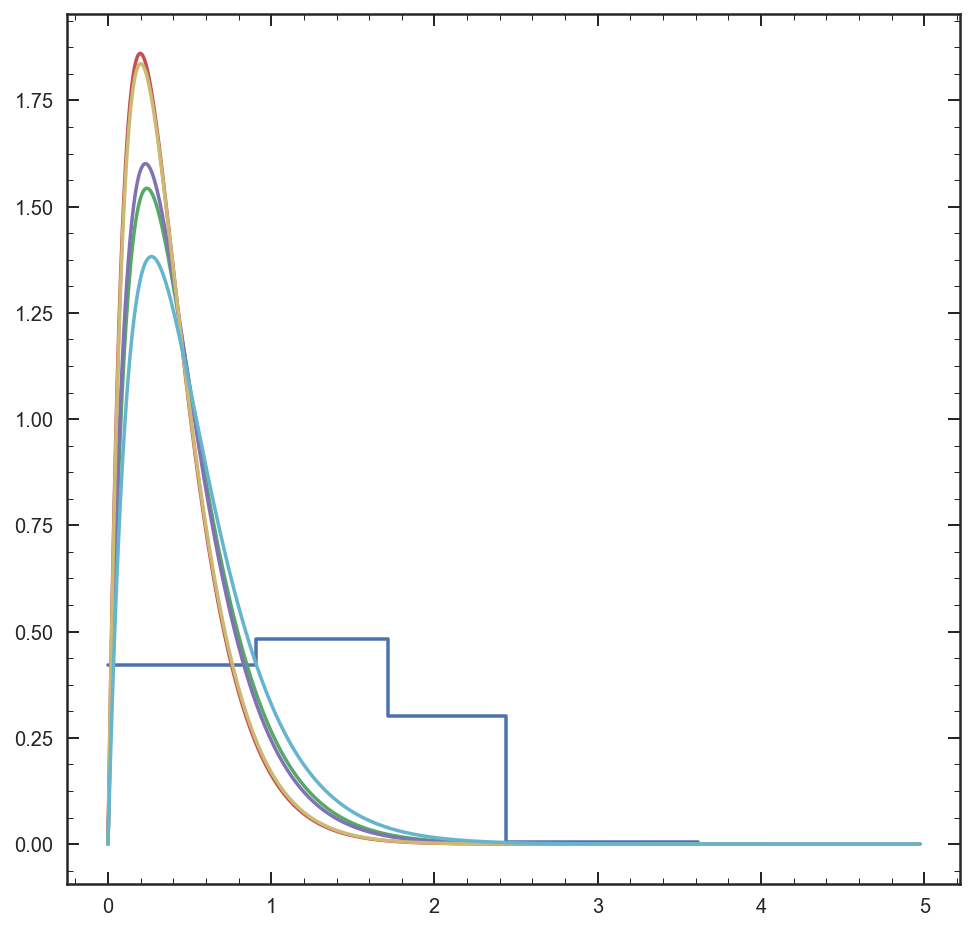

In [21]:
T= np.arange(0,Oldest_galaxy(1.25)+.001,.001)

plt.figure(figsize=[8,8])
plt.step(np.append(0,LBT), np.append(tabsfh[0], tabsfh))


for i in range(5):
    dres = np.load('../data/out_dict/sim_test_tab_to_delay_{0}.npy'.format(i+1)).item()
    
    t,pt = Get_posterior(dres.samples[:,2], dres.logwt,dres.logz)

    tau = t[pt == max(pt)][0]
    
    sfh = T * np.exp(-T / tau)

    sfh /= np.trapz(sfh,T)
    
    plt.plot(T,sfh)
    print(tau)

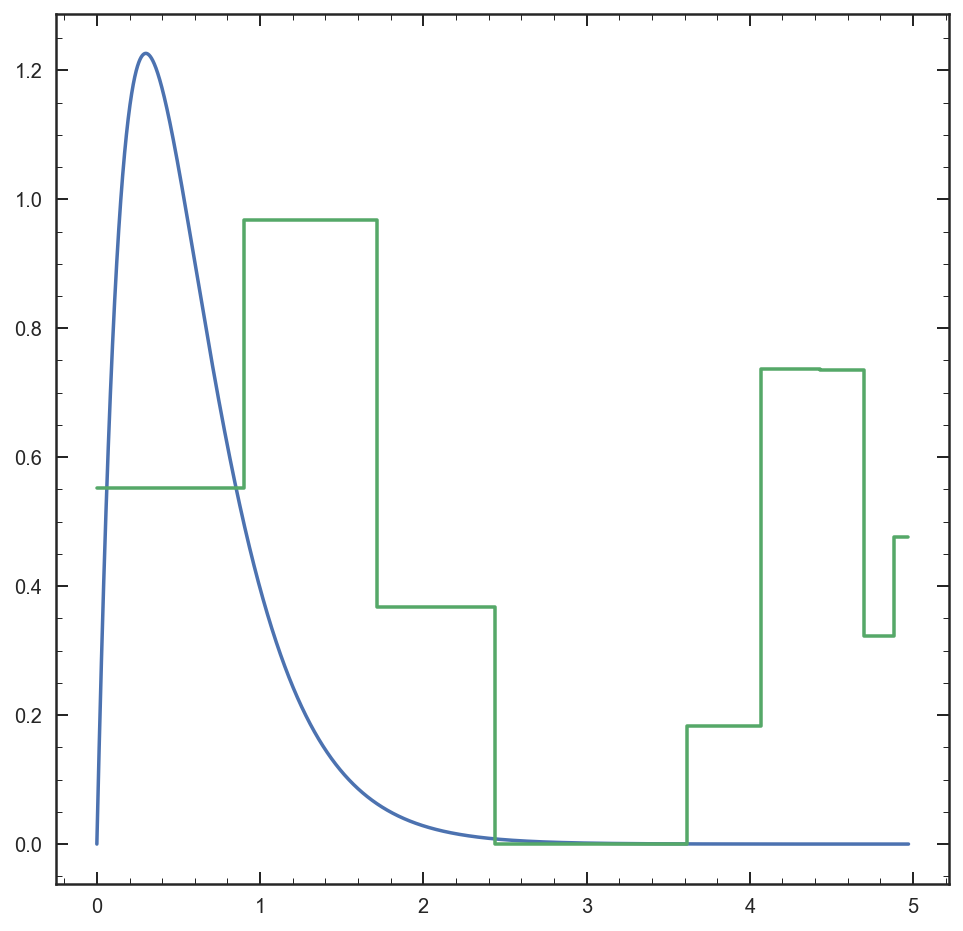

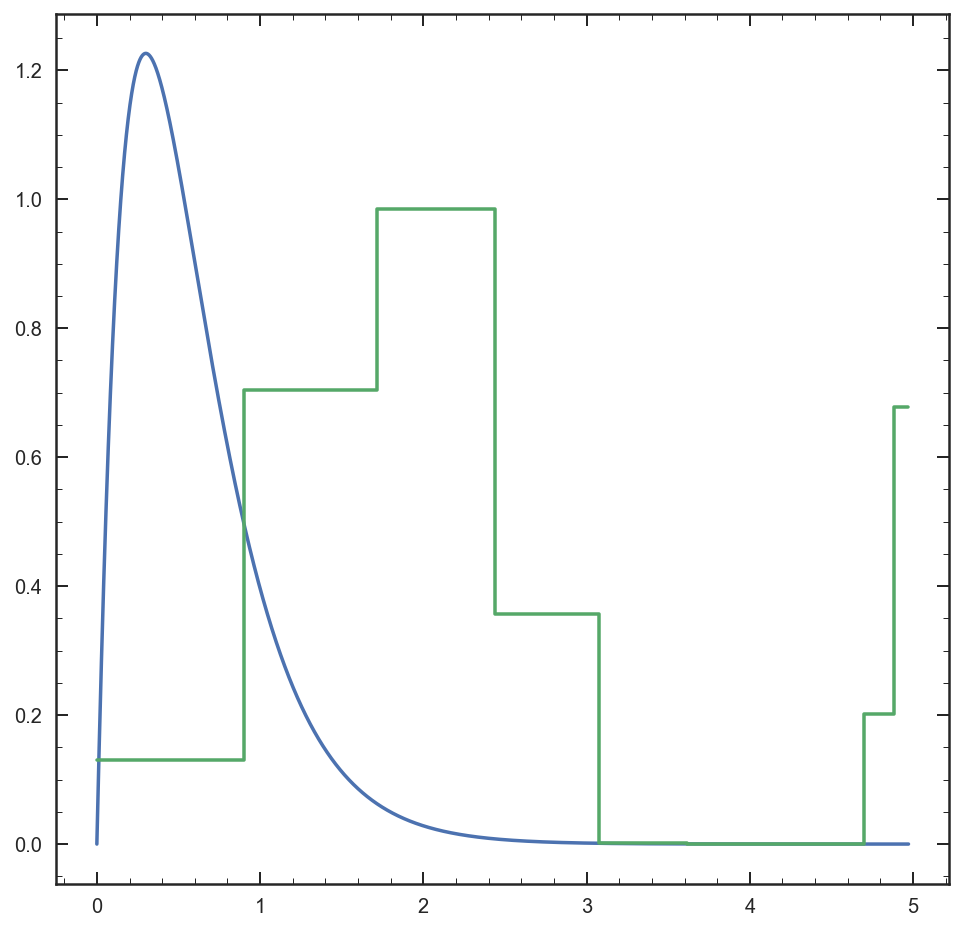

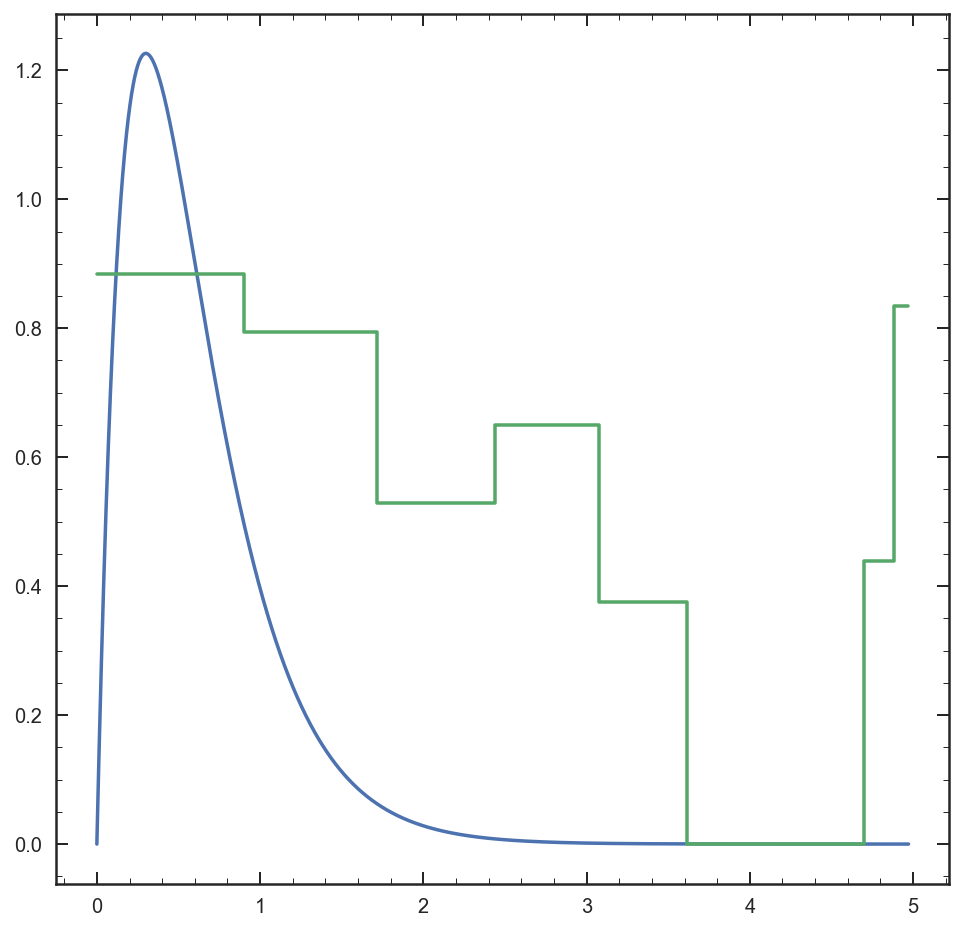

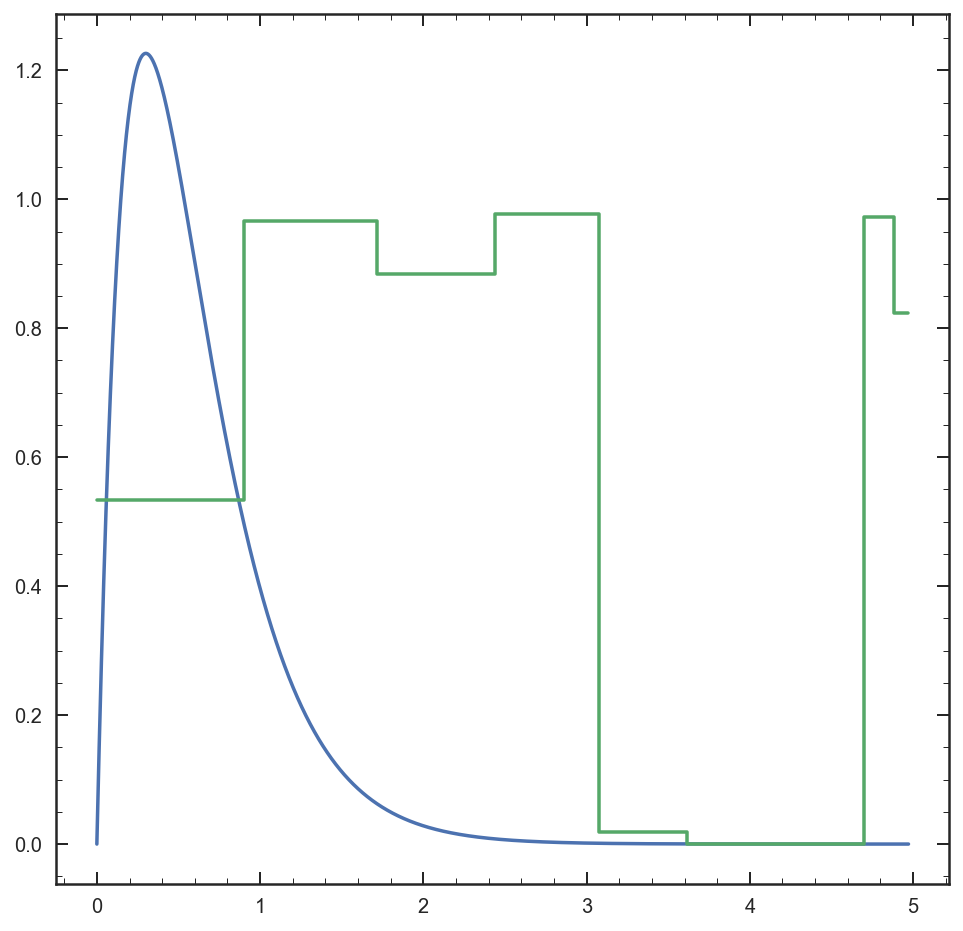

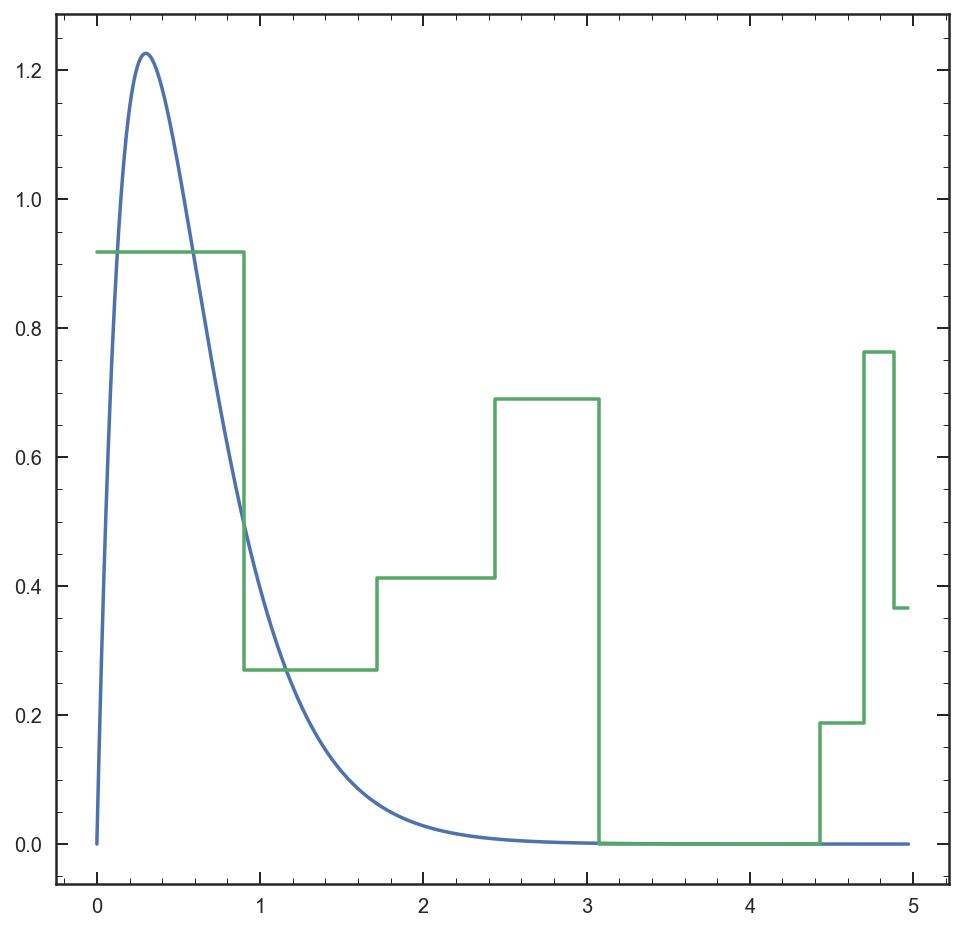

In [36]:
T= np.arange(0,Oldest_galaxy(1.25)+.001,.001)

sfh = T * np.exp(-T / 0.3)

sfh /= np.trapz(sfh,T)


# plt.figure(figsize=[8,8])
# plt.plot(T,sfh)

for i in range(5):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_{0}.npy'.format(i+1)).item()
    
    md = np.zeros(10)

    for ii in range(10):
        t,pt = Get_posterior(dres.samples[:,ii + 11],dres.logwt,dres.logz)
        md[ii], le, he = Highest_density_region(pt,t)
    plt.figure(figsize=[8,8])
    plt.plot(T,sfh)
    plt.step(np.append(0,LBT), np.append(md[0],md))


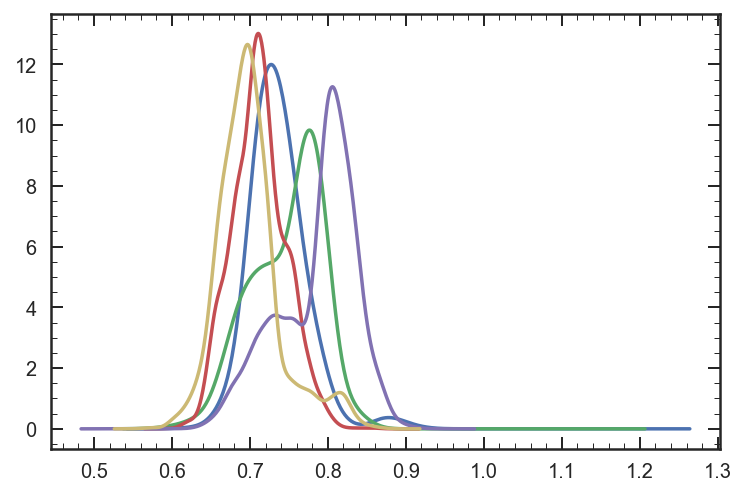

In [22]:
for i in range(5):
    dres = np.load('../data/out_dict/sim_test_tab_to_delay_{0}.npy'.format(i+1)).item()
    
    t,pt = Get_posterior(dres.samples[:,0], dres.logwt,dres.logz)
    
    plt.plot(t,pt)

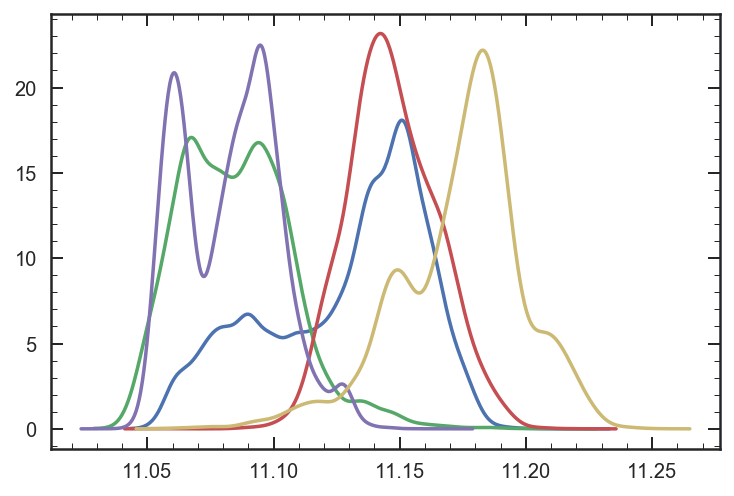

In [27]:
for i in range(5):
    dres = np.load('../data/out_dict/sim_test_tab_to_delay_{0}.npy'.format(i+1)).item()
    
    t,pt = Get_posterior(dres.samples[:,5], dres.logwt,dres.logz)
    
    plt.plot(t,pt)

In [49]:
for i in range(5):
    dres = np.load('../data/out_dict/sim_test_tab_to_delay_{0}.npy'.format(i+1)).item()
    print(dres.logl[-1])

-126.47793944555765
-131.73563682256267
-121.28571763587111
-124.55364430172011
-120.46422489743577


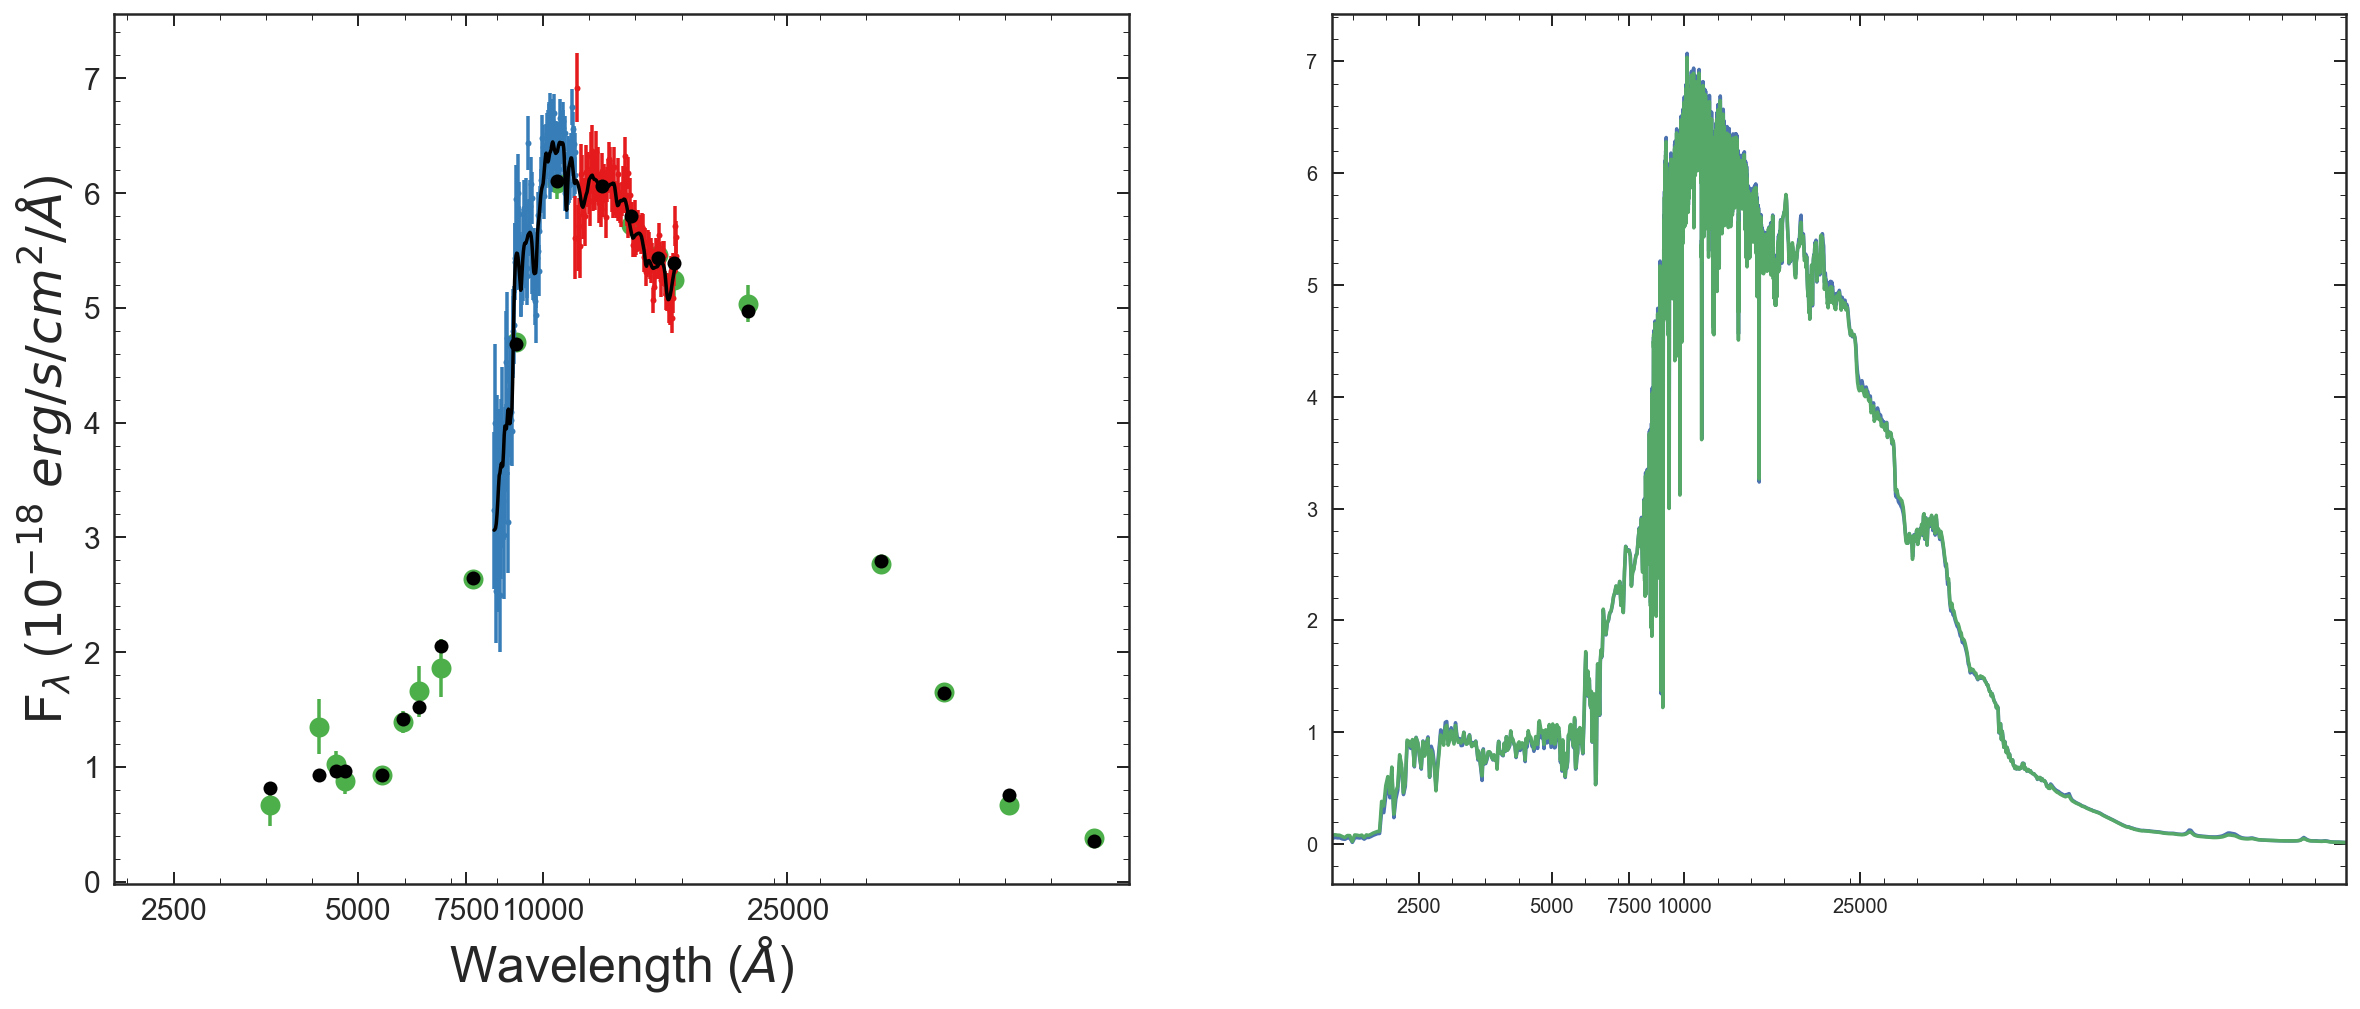

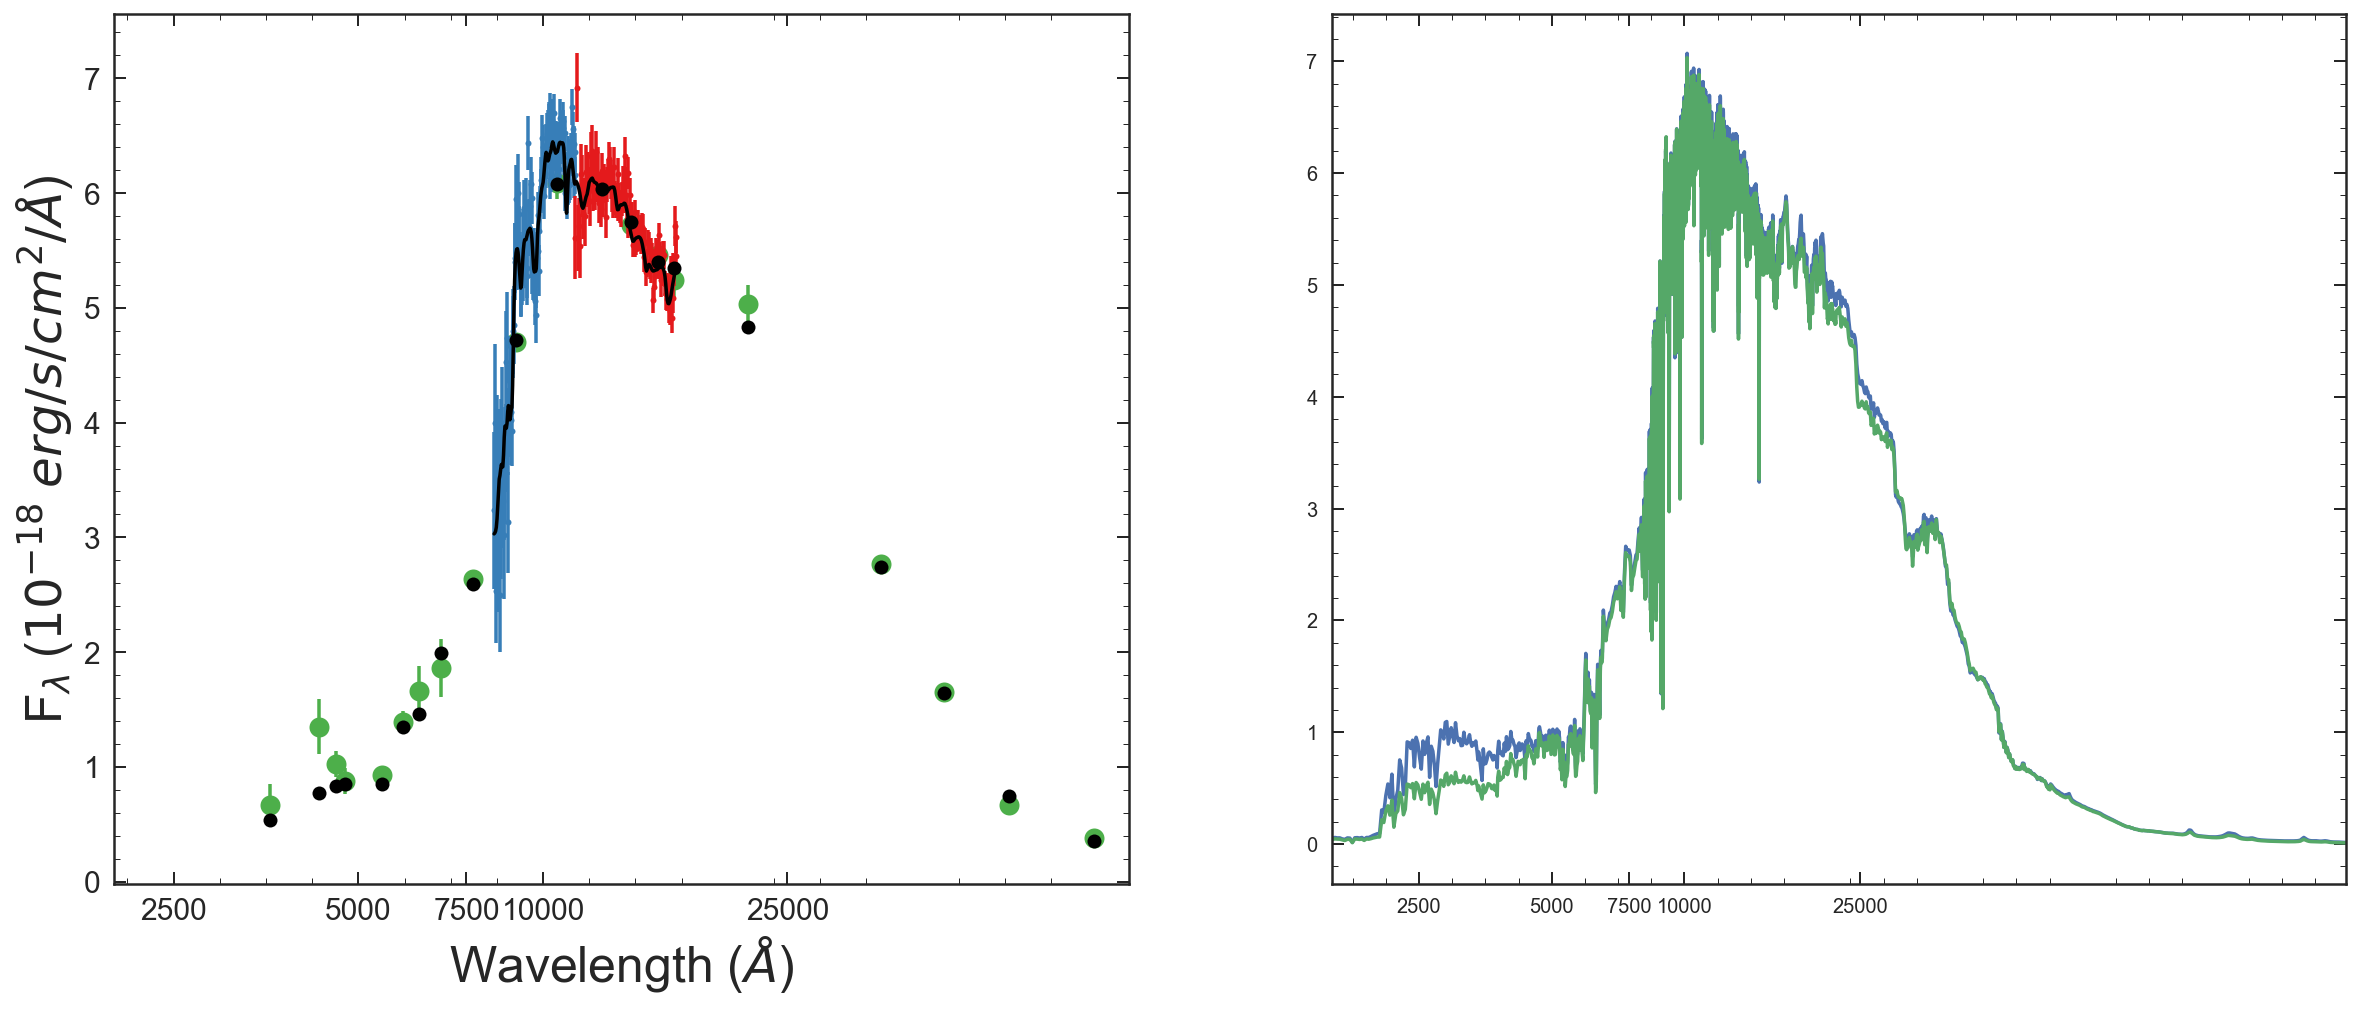

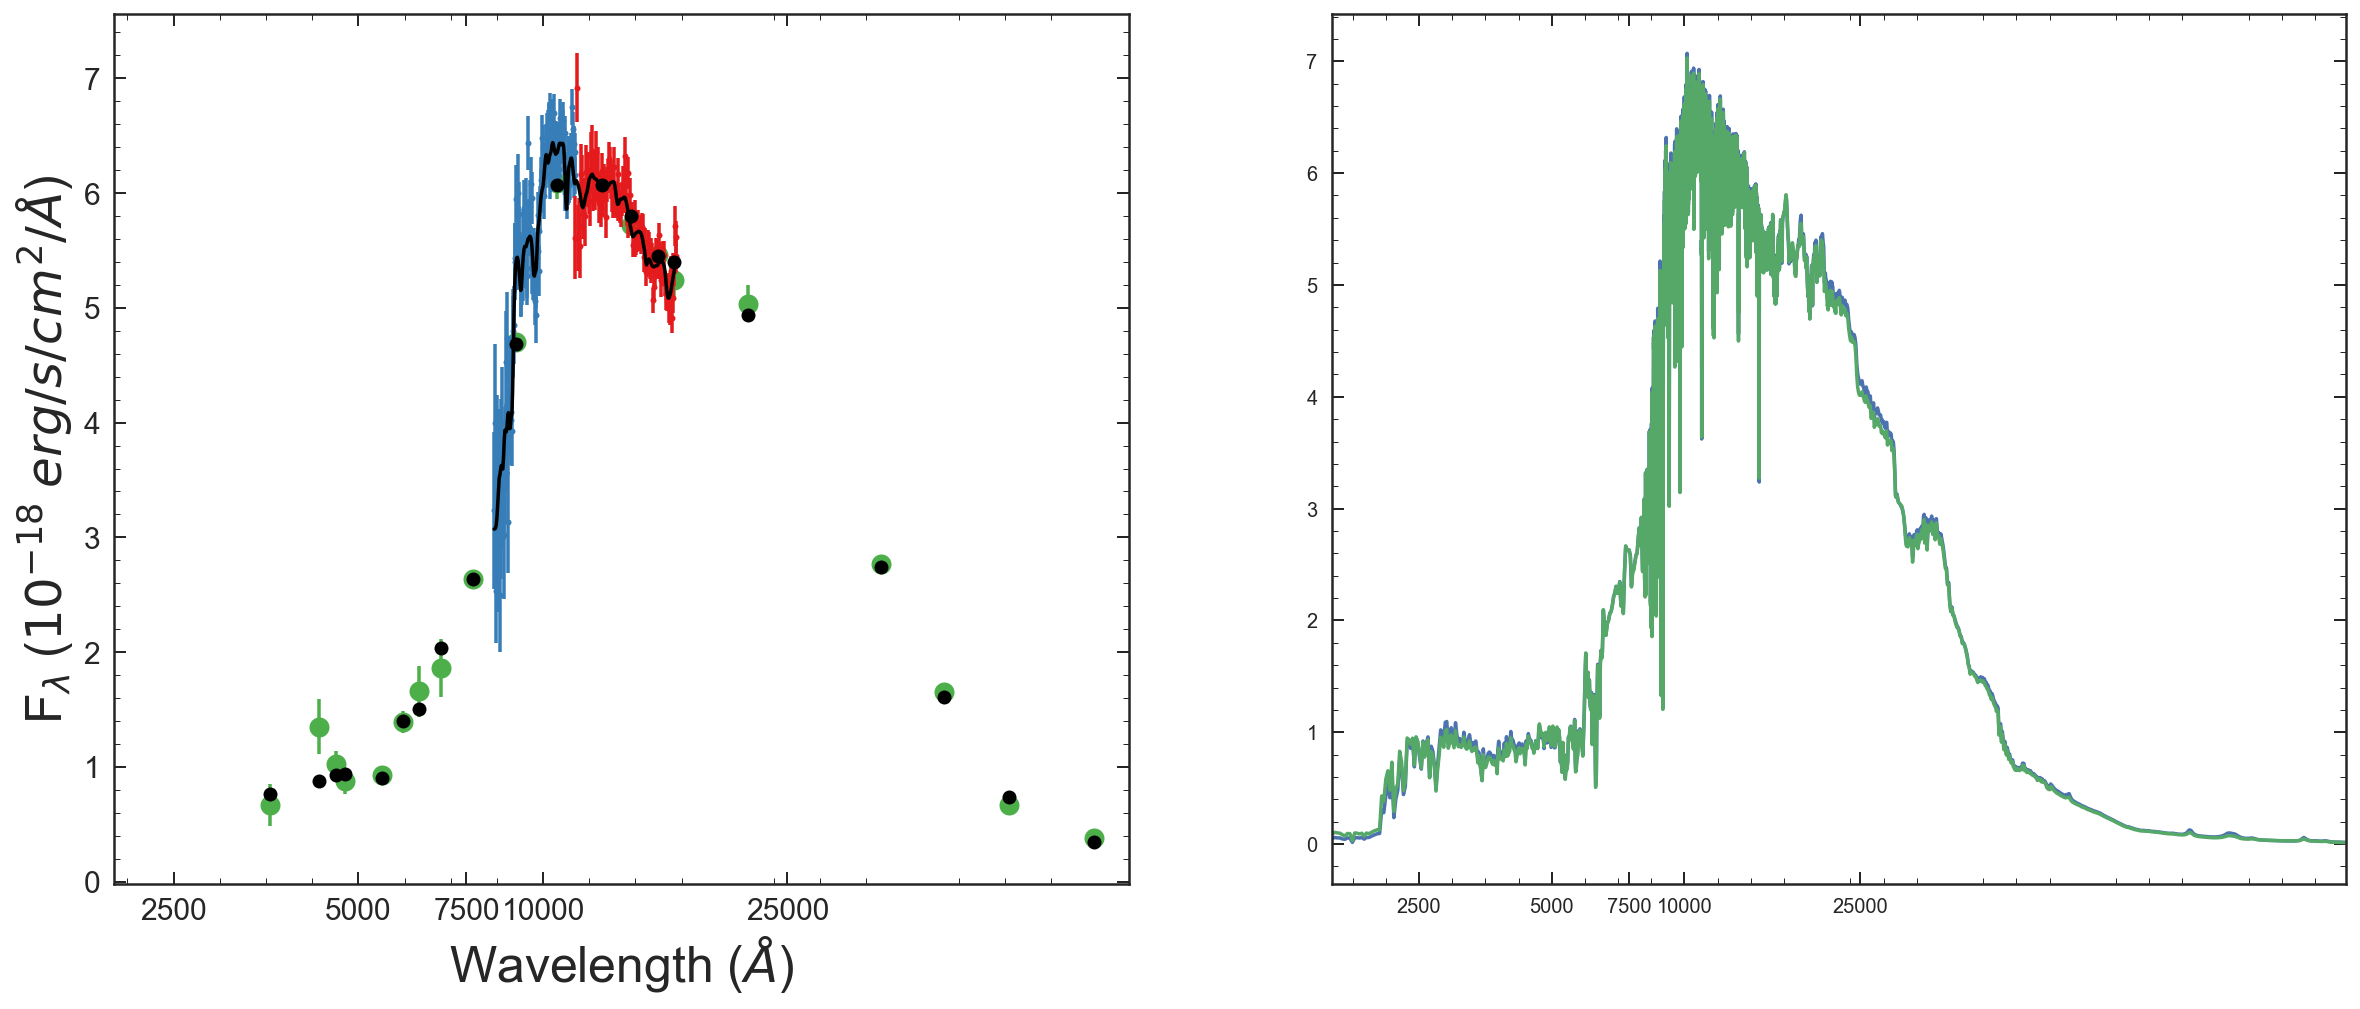

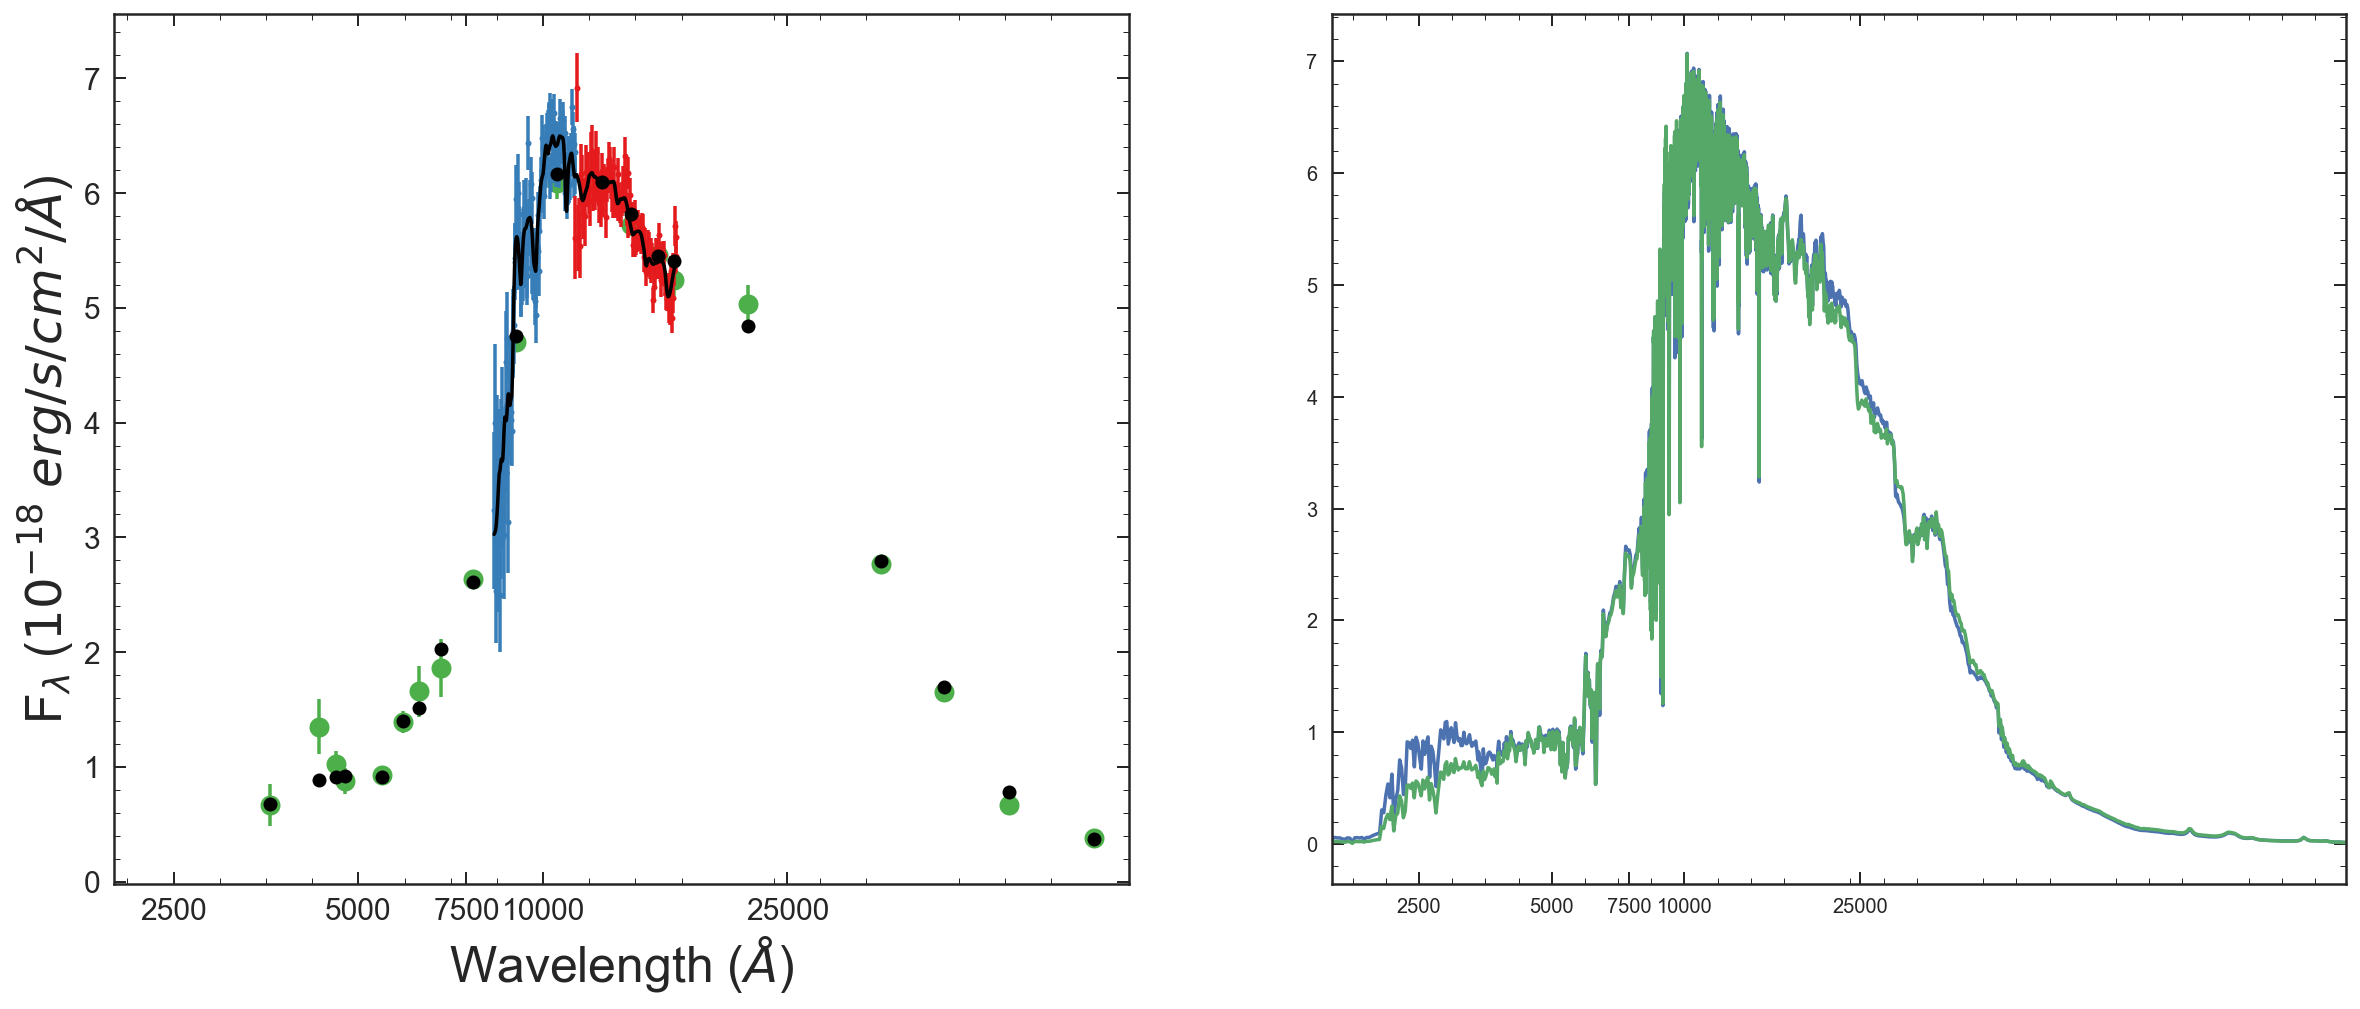

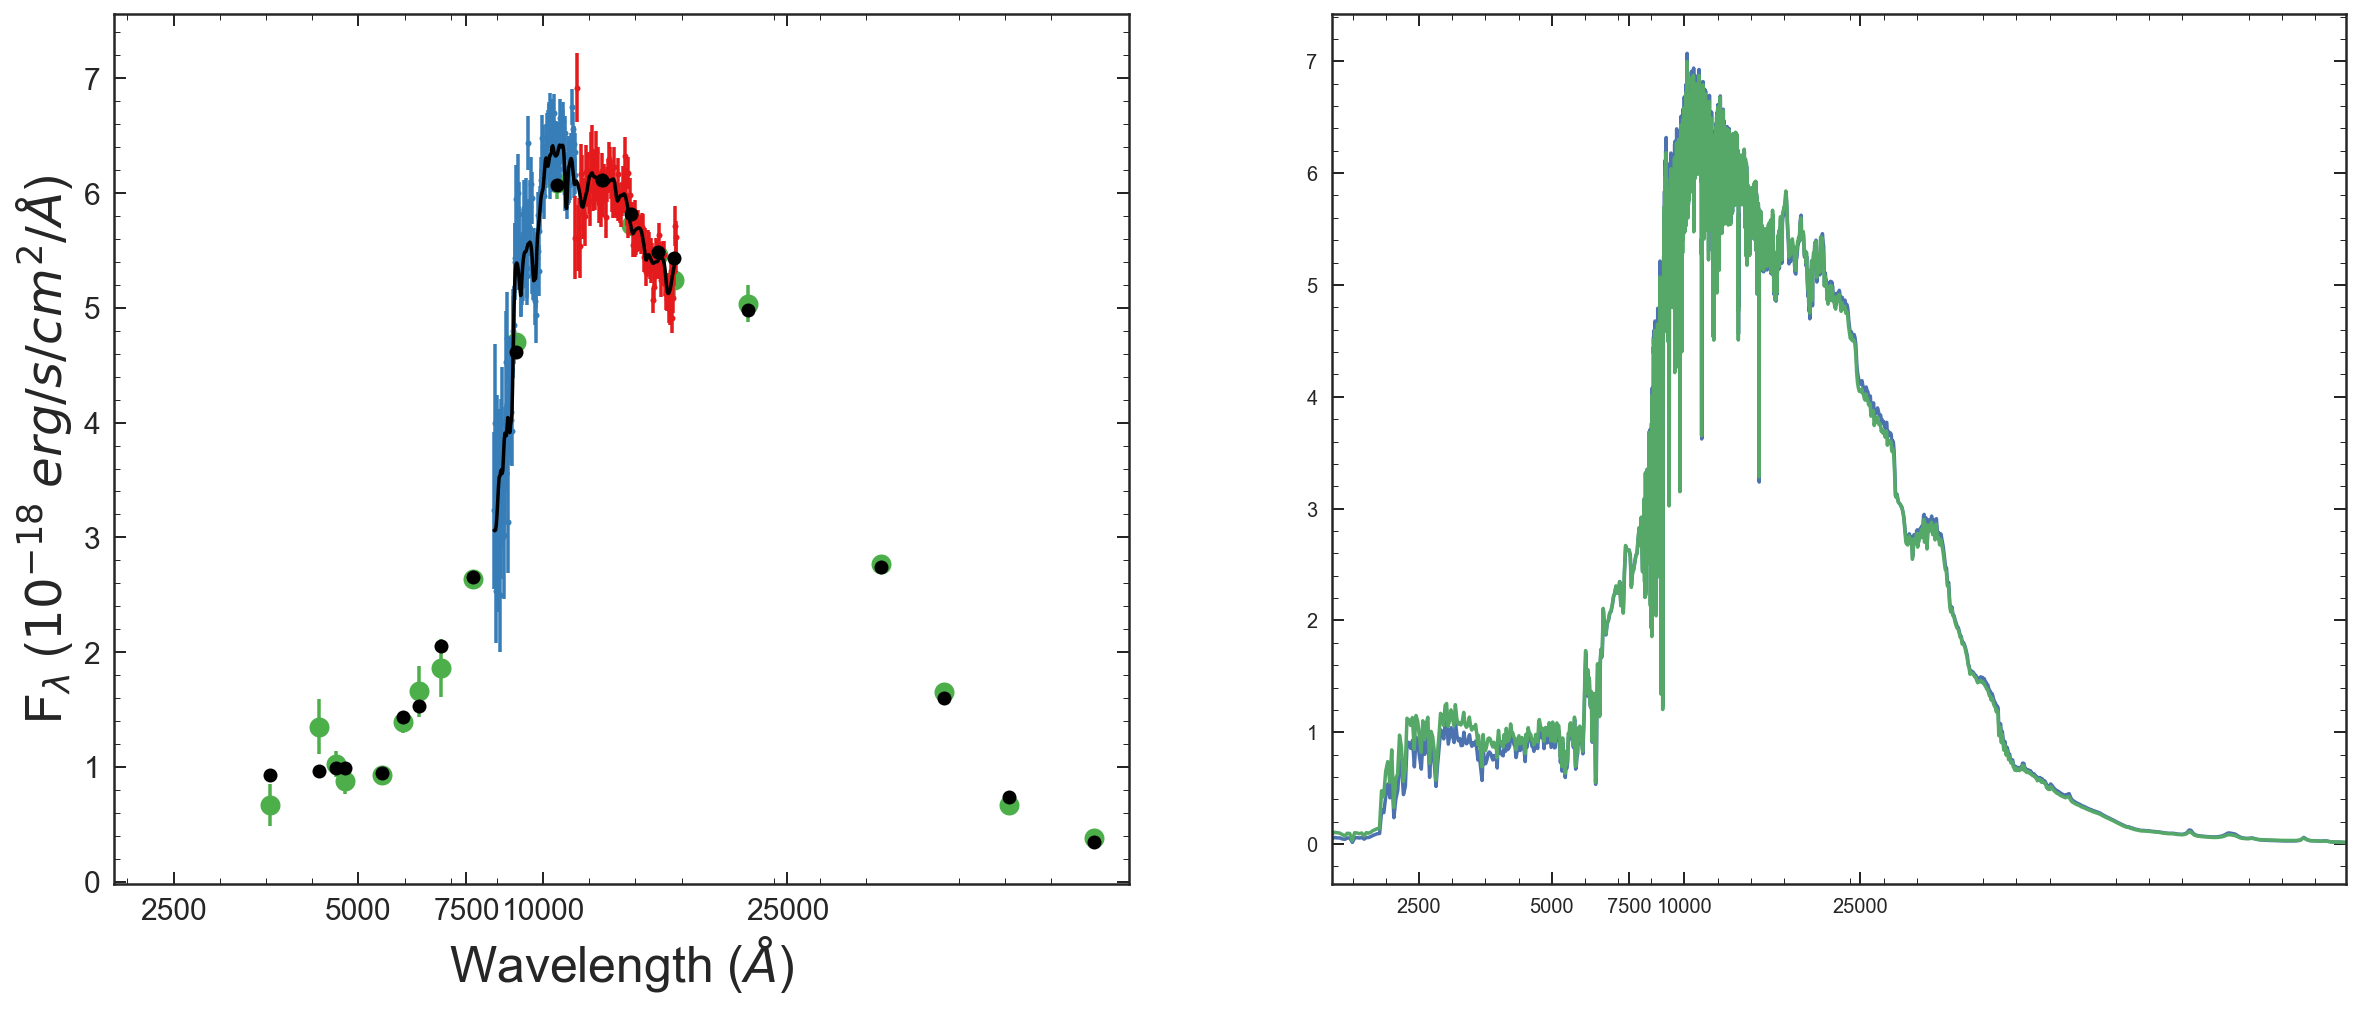

In [32]:
gs = GridSpec(1,2)

for i in range(5):
    dres = np.load('../data/out_dict/sim_test_tab_to_delay_{0}.npy'.format(i+1)).item()
    bfZ, bft, bftau, bfz, bfd, bfm = dres.samples[-1]

    sp.params['dust2'] =bfd
    sp.params['dust1'] =bfd
    sp.params['tau'] =bftau
    sp.params['logzsol'] = np.log10(bfZ)

    wavetd, fluxtd = sp.get_spectrum(tage = bft, peraa = True)
    D_l = cosmo.luminosity_distance(bfz).value # in Mpc

    sim1.Sim_all_premade(wavetd* (1+bfz), fluxtd * 10**bfm* lsol_to_fsol / (4 * np.pi * (D_l*conv)**2), scale=False)

    plt.figure(figsize = [20,8])
    plt.subplot(gs[0])
    
    
    plt.errorbar(np.log10(sim1.Bwv),sim1.SBfl*1E18,sim1.SBer*1E18,
                    linestyle='None', marker='o', markersize=3, color='#377eb8',zorder = 2, label = 'CLEAR G102')
    plt.errorbar(np.log10(sim1.Rwv),sim1.SRfl*1E18,sim1.SRer*1E18,
                    linestyle='None', marker='o', markersize=3, color='#e41a1c',zorder = 2, label = '3D-HST G141')
    plt.errorbar(np.log10(sim1.Pwv),sim1.SPflx*1E18,sim1.SPerr*1E18,
                                     linestyle='None', marker='o', markersize=10, color='#4daf4a',zorder = 1, label = '3D-HST Photometry')
    plt.plot(np.log10(sim1.Bwv), sim1.Bmfl*1E18, 'k', zorder=5)
    plt.plot(np.log10(sim1.Rwv), sim1.Rmfl*1E18, 'k', zorder=5)
    plt.plot(np.log10(sim1.Pwv), sim1.Pmfl*1E18, 'ko', zorder=5)
    # plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])
    # plt.plot(np.log10(wave * (1)),flux  / (10**bfm*1E9 * conv))
    plt.xlim(np.log10(2000), np.log10(90000))




    plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])

    plt.xlabel('Wavelength ($\AA$)', fontsize=25)
    plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=25)
    plt.tick_params(axis='both', which='major', labelsize=15)
    
    plt.subplot(gs[1])

    plt.plot(np.log10(wave1 * (1+specz)), flux1 * mass_transform*1E18)
    plt.plot(np.log10(wavetd* (1+bfz)), fluxtd * 10**bfm* lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)*1E18)
    plt.xlim(3.2,5.5)
    plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])


In [41]:
# get lightweighted age

sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 4, tau=0.1, dust_type = 1, )
sp.params['compute_light_ages'] = True

PLWA = []
LWA = []


for i in range(5):
    dres = np.load('../data/out_dict/sim_test_tab_to_delay_{0}.npy'.format(i+1)).item()
    
    lwa = []
    
    for ii in range(len(dres.samples)):
        bfZ, bft, bftau, bfz, bfd, bfm = dres.samples[ii]

        sp.params['dust2'] =bfd
        sp.params['dust1'] =bfd
        sp.params['tau'] =bftau
        sp.params['logzsol'] = np.log10(bfZ)

        lwa.append(sp.get_mags(tage = bft, bands =['sdss_g'])[0])
    
    t,pt = Get_posterior(np.array(lwa), dres.logwt,dres.logz)
    LWA.append(t)
    PLWA.append(pt)
    
        
sp.params['compute_light_ages'] = False
        

In [44]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 3, sfh = 3, dust_type = 1)
sp.params['compute_light_ages'] = True

sp.params['dust2'] =0.2
sp.params['dust1'] =0.2

tab_sfh = np.array([0.7, 0.8, 0.5, 0.01, 0.01, 0.001, 0.00001, 0.0002, 0.002, 0.0001])
tab_Z = np.array([0.2, 0.8, 1.0, 1.0, 0.8, 1.1, 0.7, 0.8, 0.8, 0.8])*0.019

sp.set_tabular_sfh(LBT,tab_sfh,
                   Z = tab_Z )

lwa1 = sp.get_mags(tage = 3.5, bands =['sdss_g'])
       
sp.params['compute_light_ages'] = False

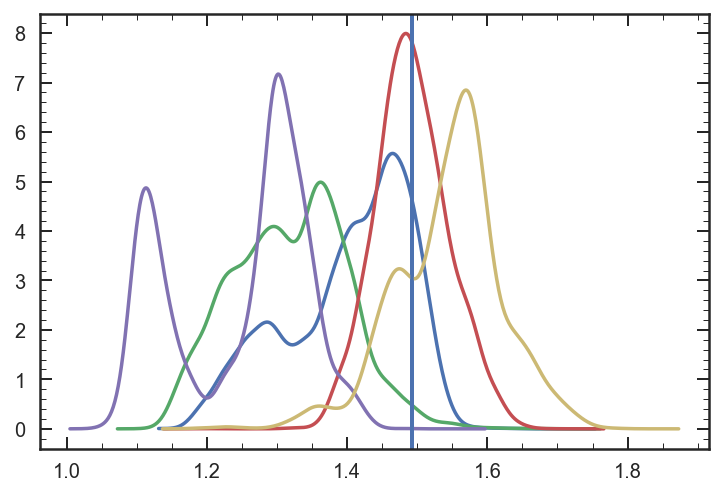

In [45]:
for i in range(5):
    plt.plot(LWA[i], PLWA[i])
    plt.axvline(lwa1)

-180.0196283199227
-147.69070596860846
-271.37299584599407
-178.89964759230114
-178.5015123487717


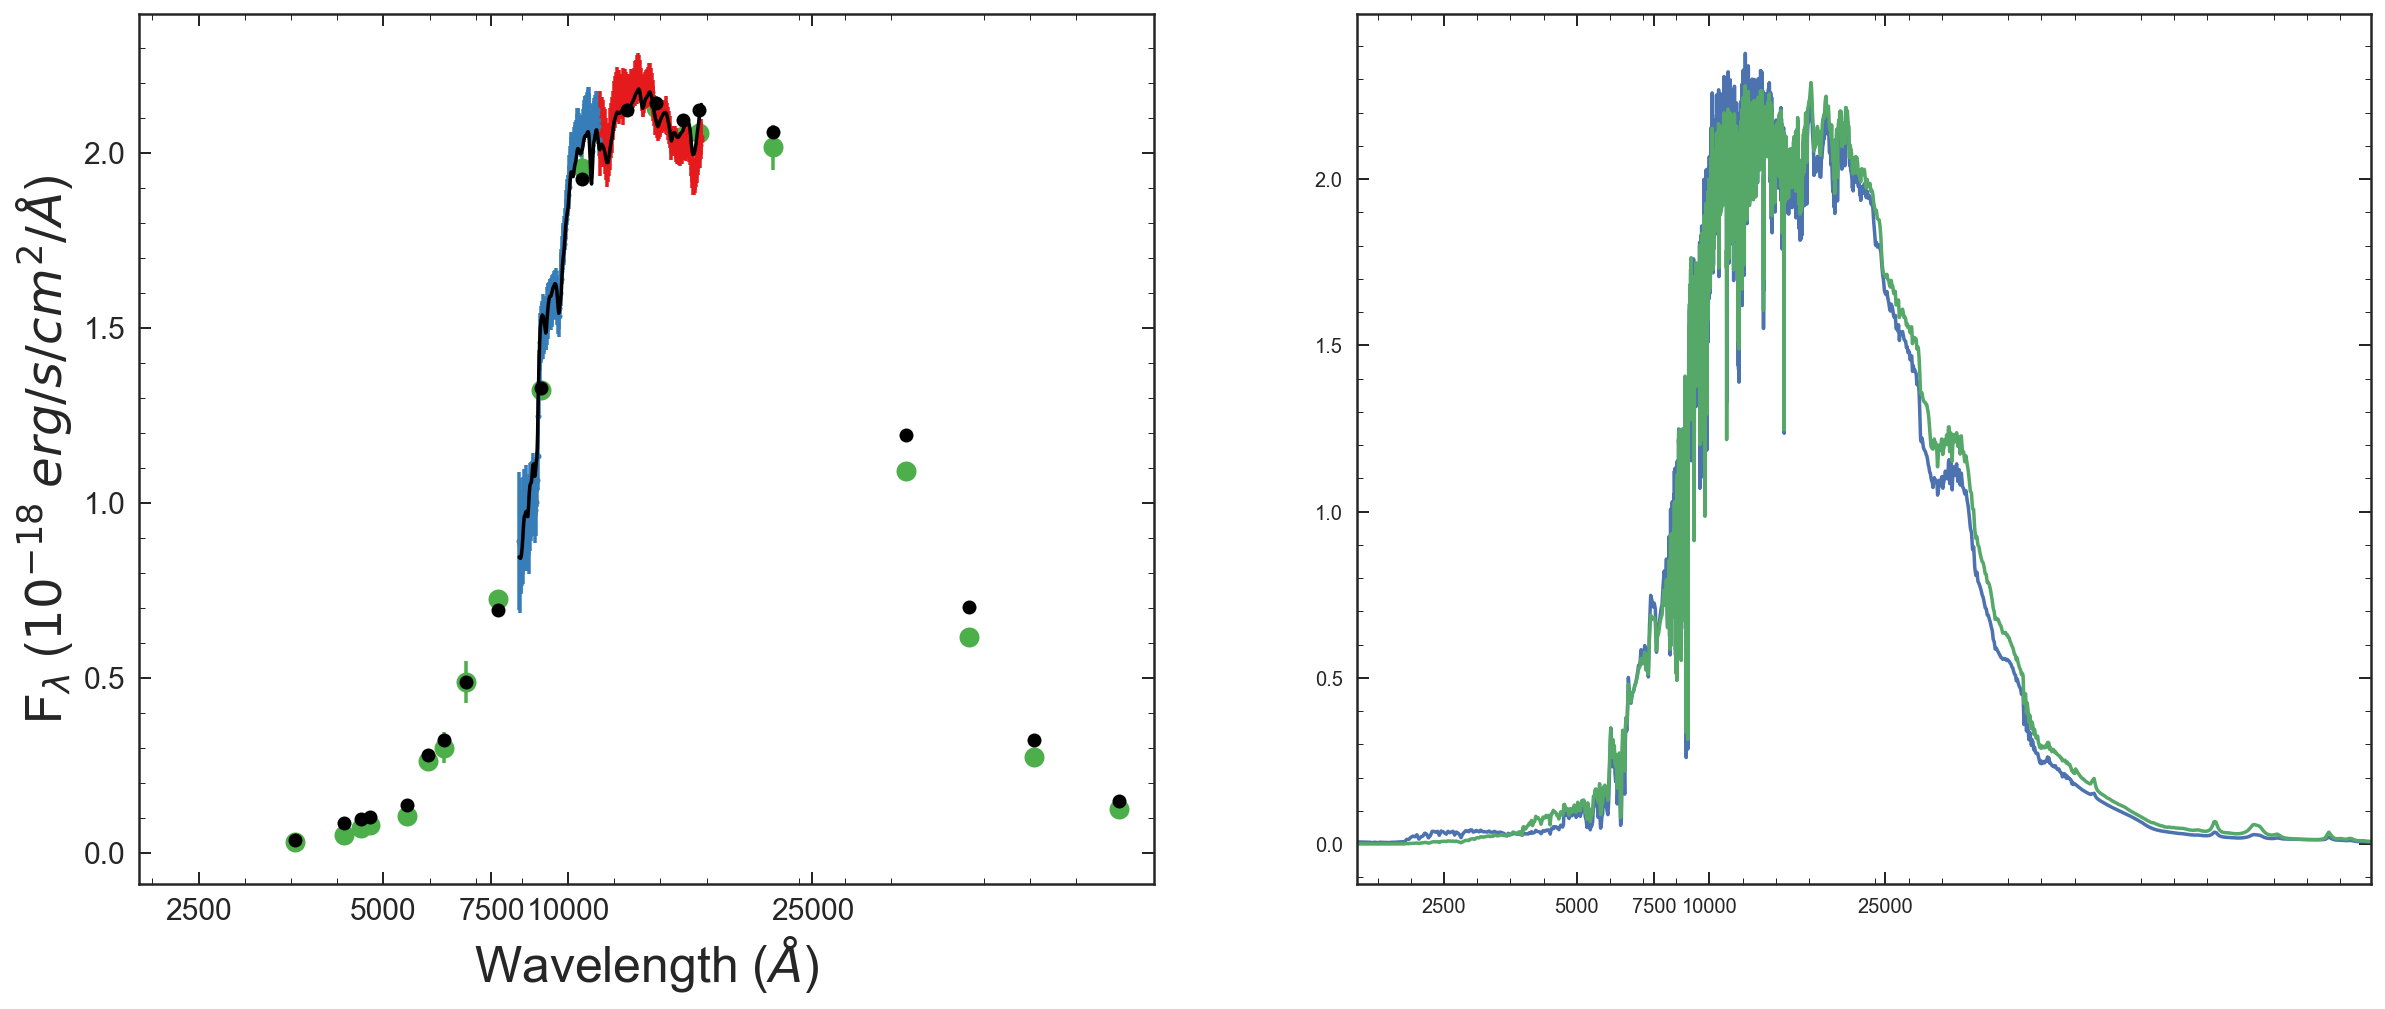

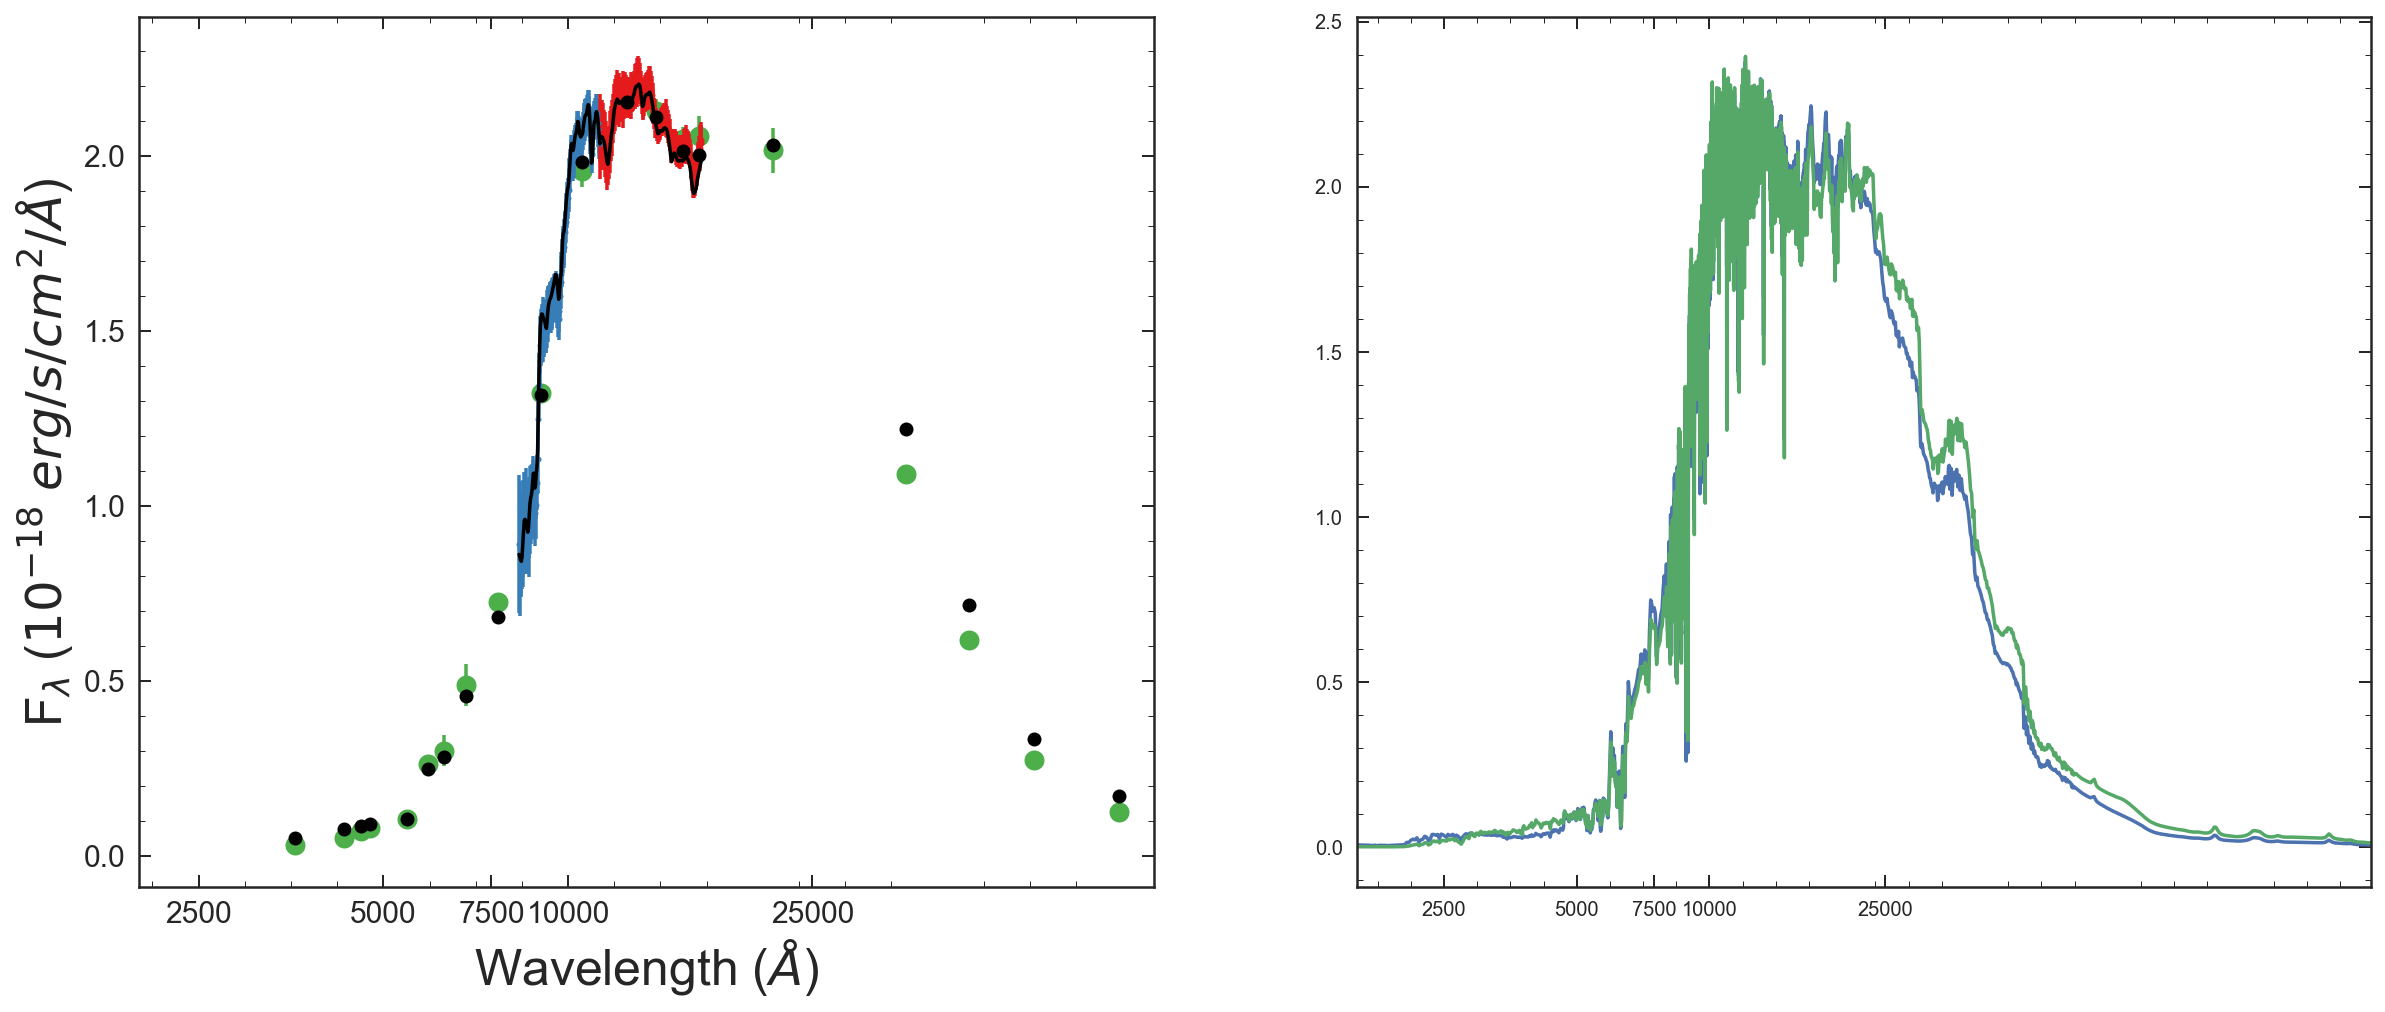

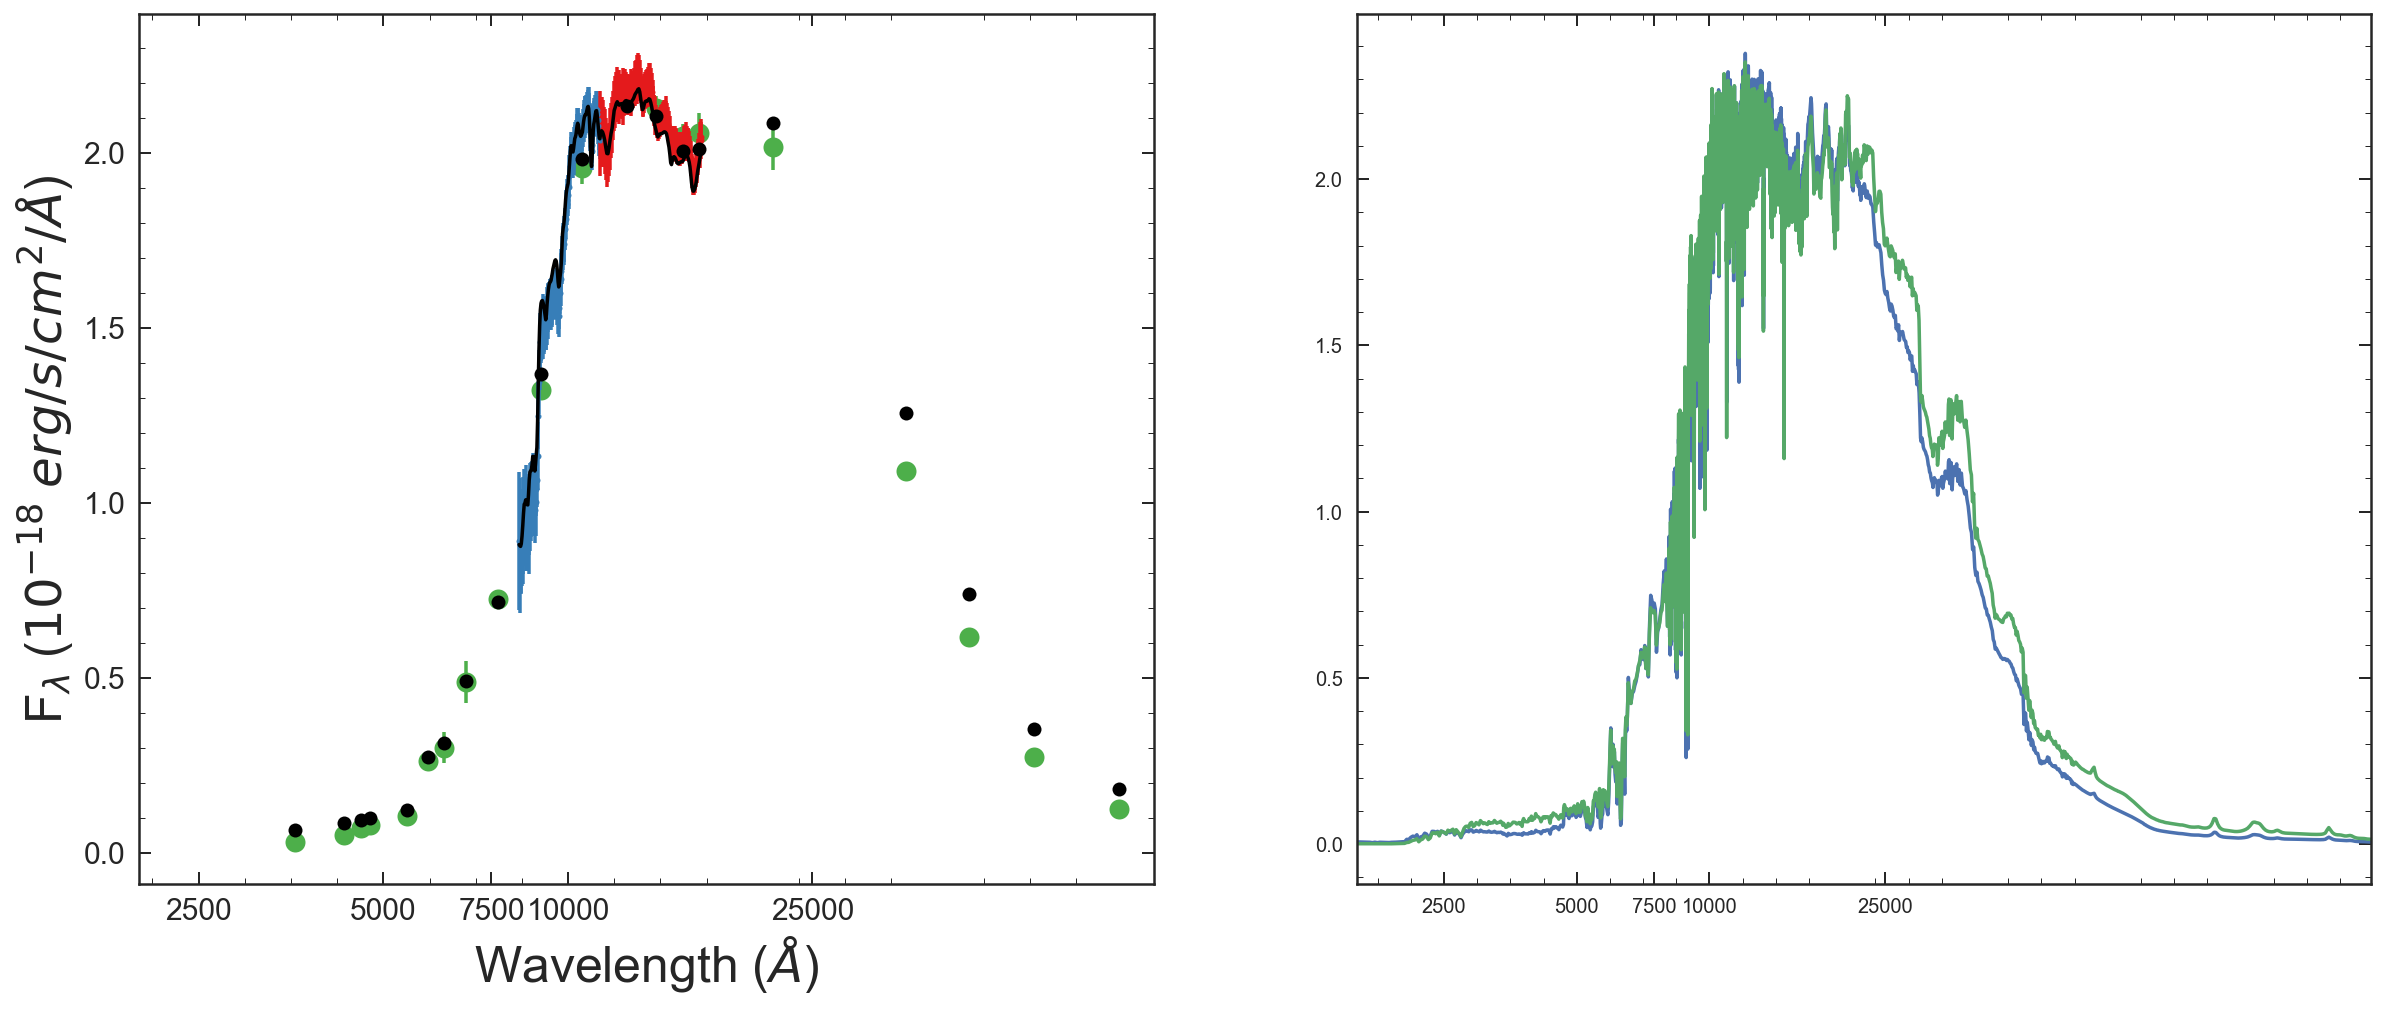

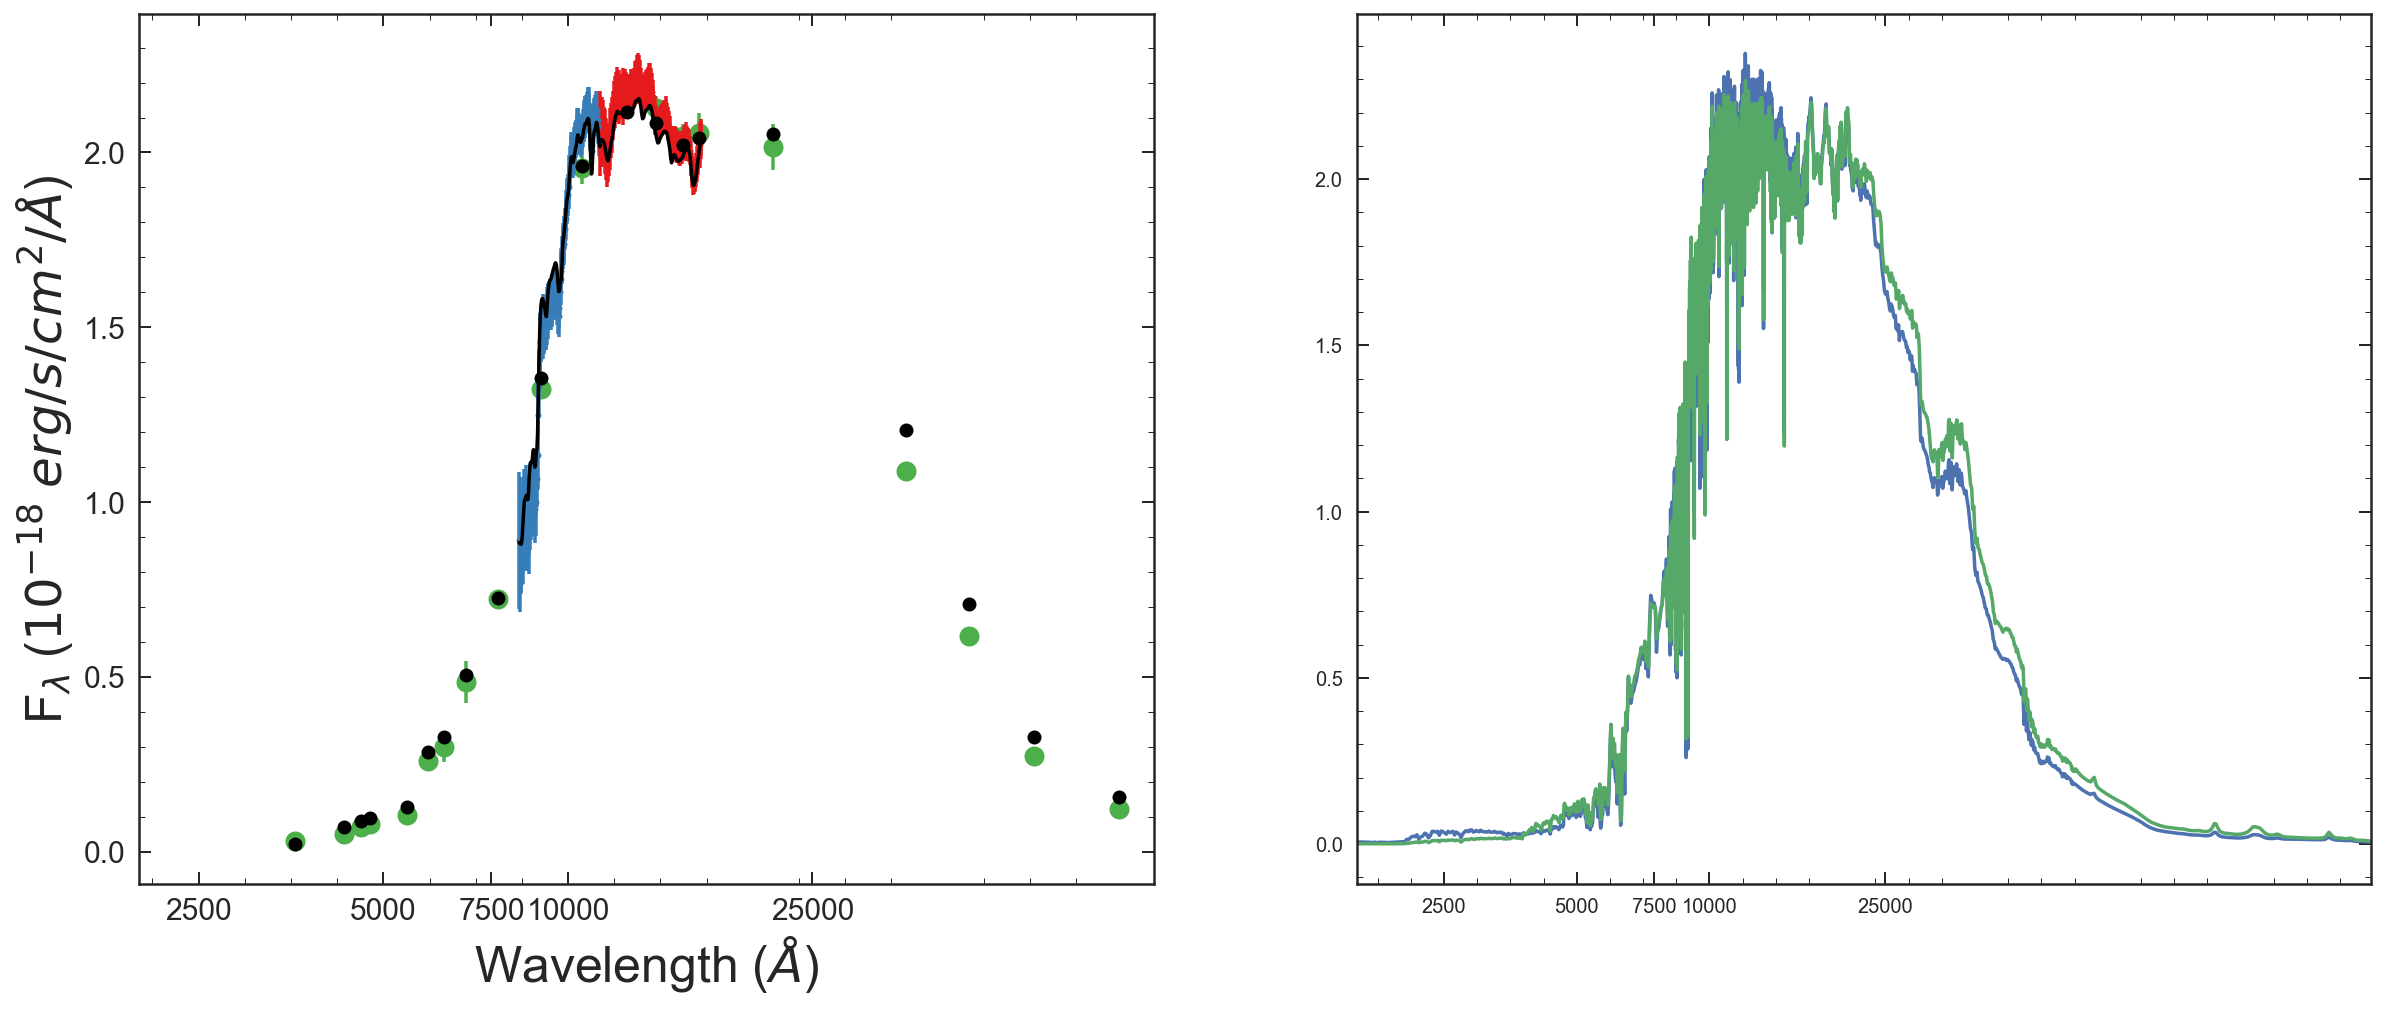

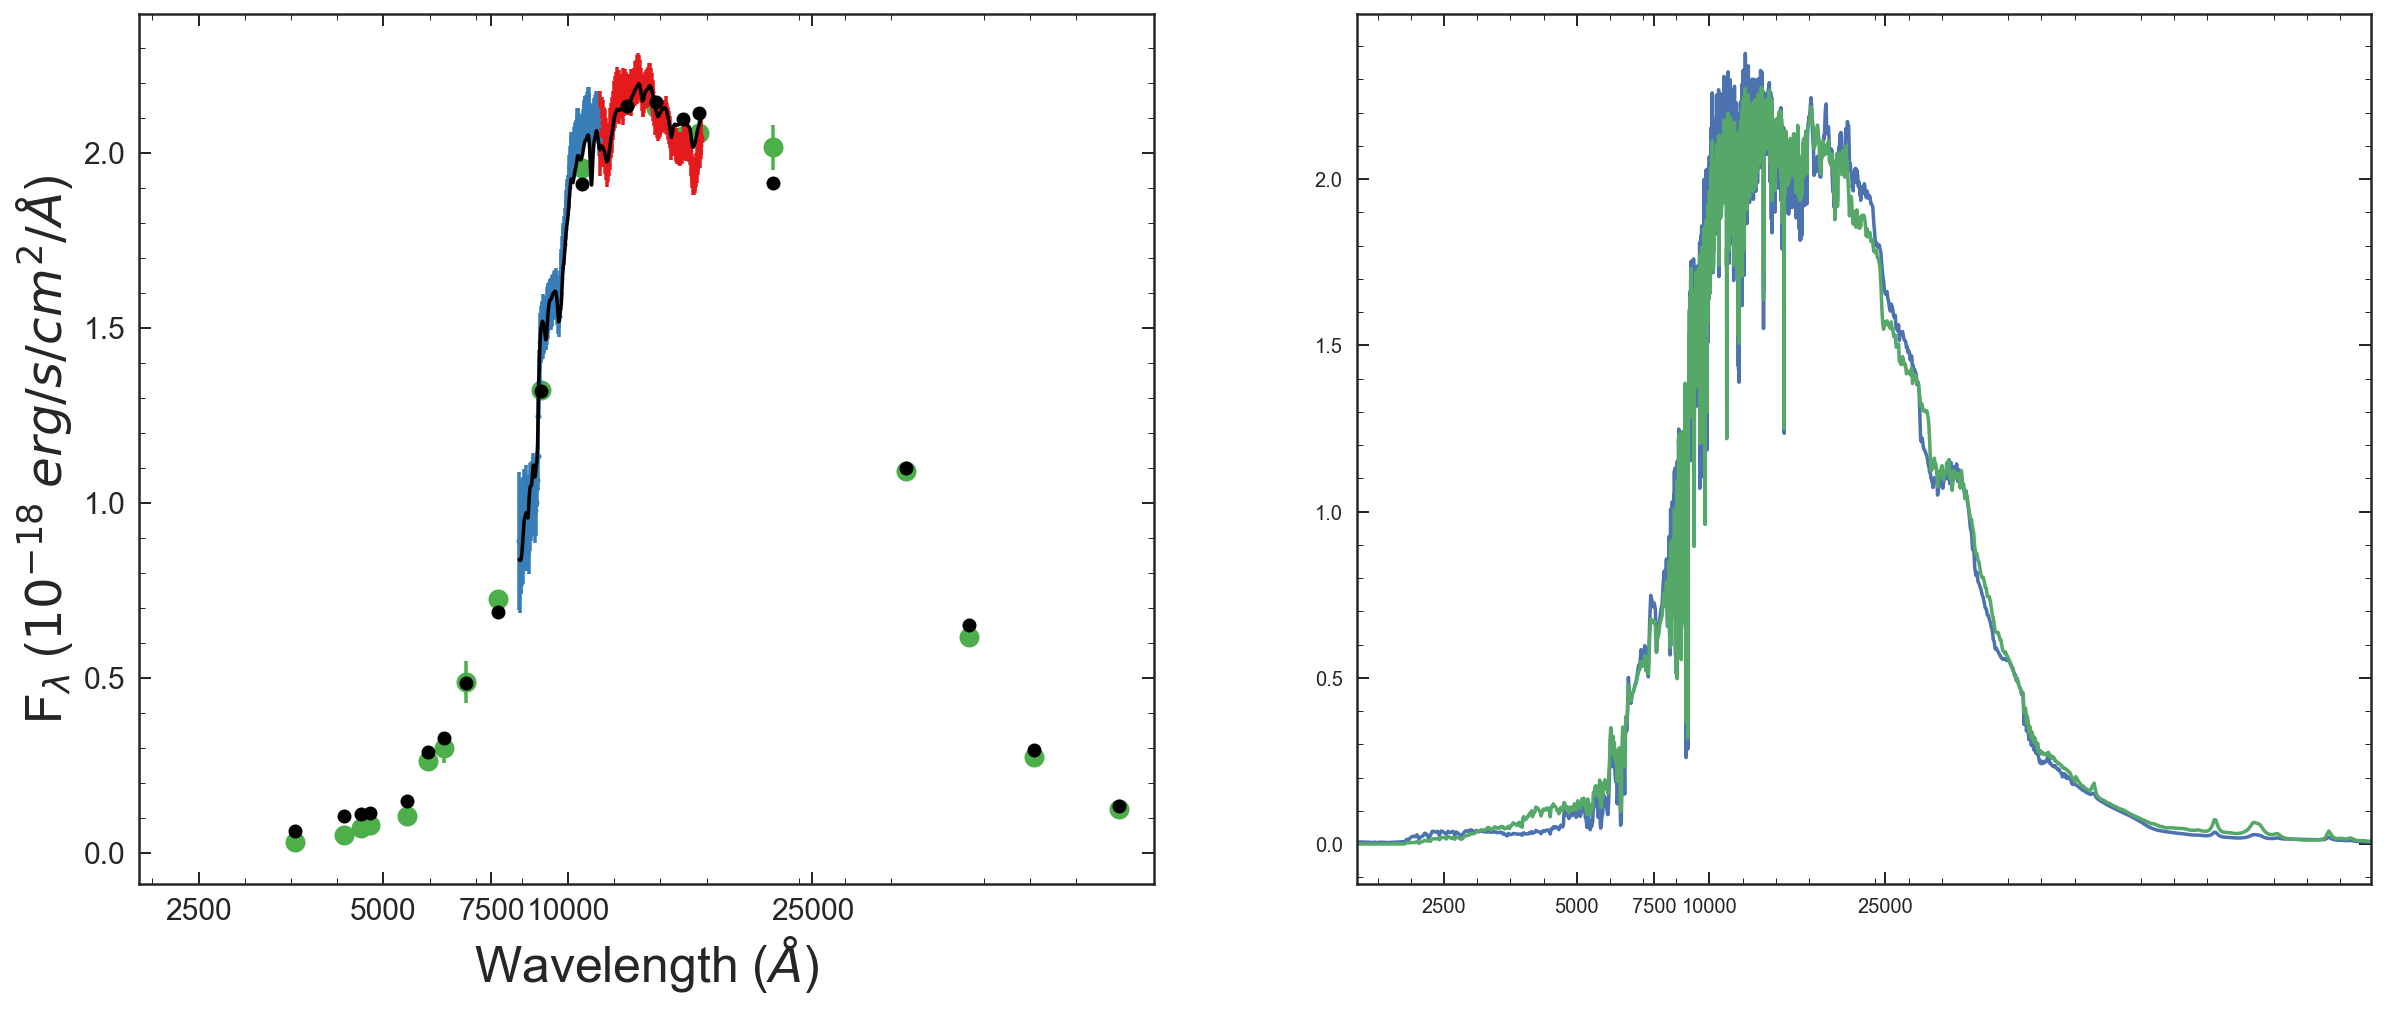

In [45]:
gs = GridSpec(1,2)

sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 3, dust_type = 1)

conv = 3.086E24 # Mpc to cm
lsol_to_fsol = 3.839E33 # change L_/odot to F_/odot

D_l = cosmo.luminosity_distance(1.25).value # in Mpc

d_mass_T = 10**11* lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)

for i in range(5):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_delay_prior{0}.npy'.format(i+1)).item()

    bfZ, bft,bftau1, bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10,\
    bfz, bfd, bfm = dres.samples[-1]

    sp.params['dust2'] = bfd
    sp.params['dust1'] = bfd
    sp.params['logzsol'] = np.log10(bfZ)
    sp.set_tabular_sfh(LBT,np.array([bftau1, bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10]))

    wavedt, fluxdt = sp.get_spectrum(tage = bft, peraa = True)
    D_l = cosmo.luminosity_distance(bfz).value # in Mpc

    mass_T = (10**bfm / sp.stellar_mass) * lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)  

    sim2.Sim_all_premade(wavedt* (1+bfz), fluxdt * mass_T, scale=False)

    plt.figure(figsize = [20,8])
    plt.subplot(gs[0])

    plt.errorbar(np.log10(sim2.Bwv),sim2.SBfl*1E18,sim2.SBer*1E18,
                    linestyle='None', marker='o', markersize=3, color='#377eb8',zorder = 2, label = 'CLEAR G102')
    plt.errorbar(np.log10(sim2.Rwv),sim2.SRfl*1E18,sim2.SRer*1E18,
                    linestyle='None', marker='o', markersize=3, color='#e41a1c',zorder = 2, label = '3D-HST G141')
    plt.errorbar(np.log10(sim2.Pwv),sim2.SPflx*1E18,sim2.SPerr*1E18,
                                     linestyle='None', marker='o', markersize=10, color='#4daf4a',zorder = 1, label = '3D-HST Photometry')
    plt.plot(np.log10(sim2.Bwv), sim2.Bmfl*1E18, 'k', zorder=5)
    plt.plot(np.log10(sim2.Rwv), sim2.Rmfl*1E18, 'k', zorder=5)
    plt.plot(np.log10(sim2.Pwv), sim2.Pmfl*1E18, 'ko', zorder=5)

    plt.xlim(np.log10(2000), np.log10(90000))

    plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])

    plt.xlabel('Wavelength ($\AA$)', fontsize=25)
    plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=25)
    plt.tick_params(axis='both', which='major', labelsize=15)

    plt.subplot(gs[1])

    plt.plot(np.log10(wave2 * (1+specz)), flux2 * d_mass_T*1E18)
    plt.plot(np.log10(wavedt* (1+bfz)), fluxdt * mass_T * 1E18)
    plt.xlim(3.2,5.5)
    plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])

    print((sum(((sim2.SBfl - sim2.Bmfl) / sim2.SBer)**2) + sum(((sim2.SRfl - sim2.Rmfl) / sim2.SRer)**2) \
           + sum(((sim2.SPflx - sim2.Pmfl) / sim2.SPerr)**2)) * (-0.5))

In [14]:
specz= 1.25

from prospect.models.transforms import *
lages = [0,8,8.25,8.5,8.75,9,9.25,9.5,9.75,10,10.25]

lagebins = []

for i in range(len(lages)-1):
    lagebins.append([lages[i], lages[i+1]])

upd_lagebins = zred_to_agebins(zred=specz, agebins=lagebins)

LBT = (10**upd_lagebins.T[1][::-1][0] - 10**upd_lagebins.T[0][::-1])*1E-9

-335.9711013931561
-296.7855533546633
-231.66735365329575
-70.48566061470667
-312.6339603506392
------------------
-374.04336403403096
-154.45716778259916
-355.018795552277
-269.38456426873927
-345.6159670174862
------------------
-242.34363499564944
-152.20364738216395
-266.3930189977585
-283.9021153165273
-160.27166219693055
------------------
-114.26735837084266
-141.89615220400628
-185.91945597573243
-156.20028002042733
-223.8442799960465


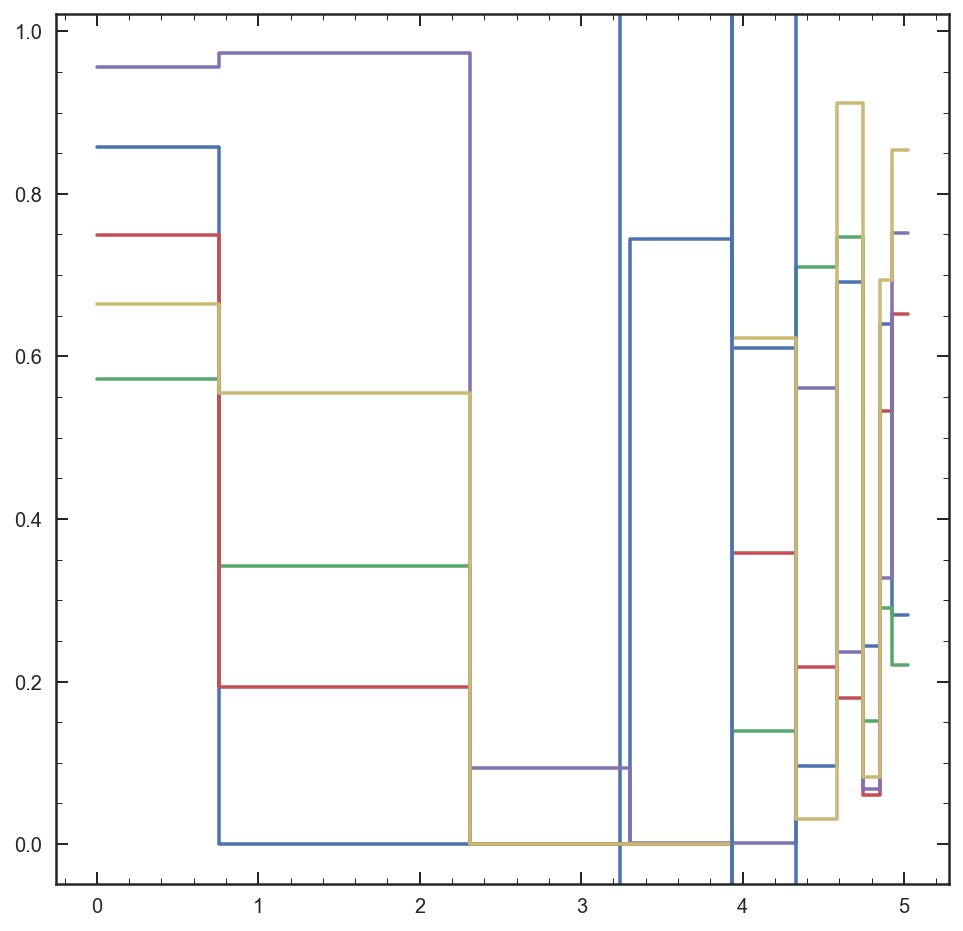

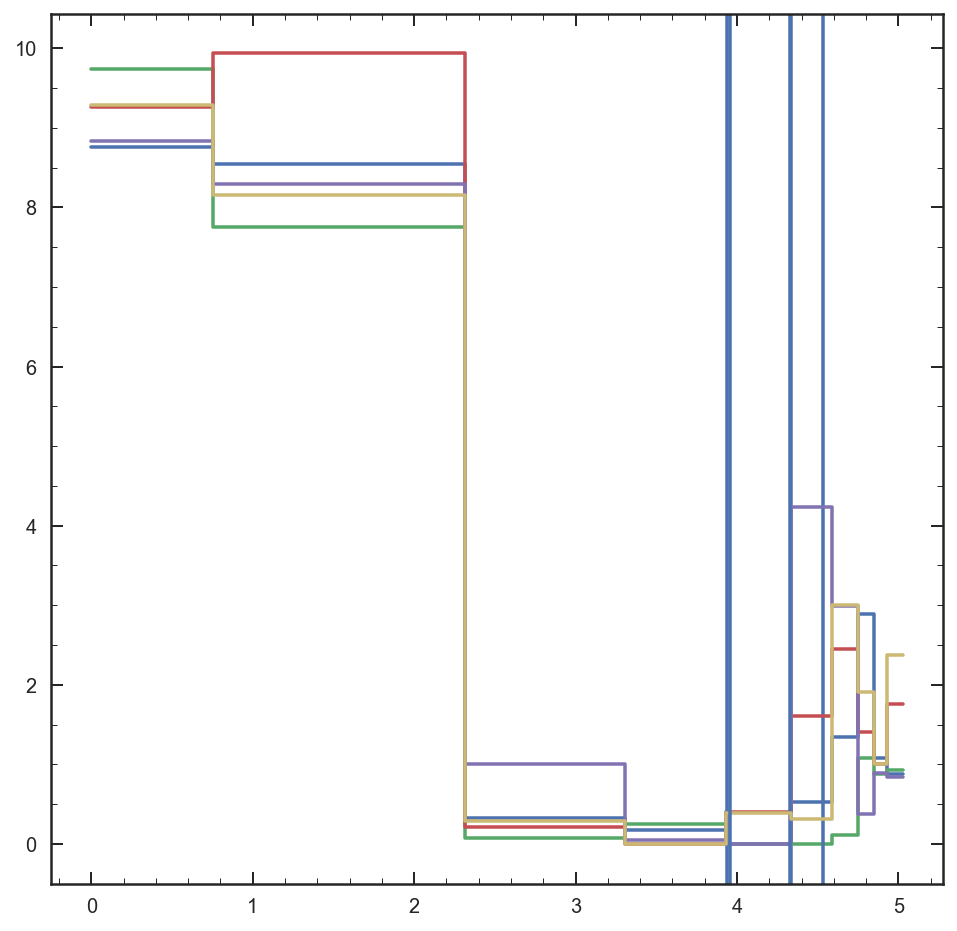

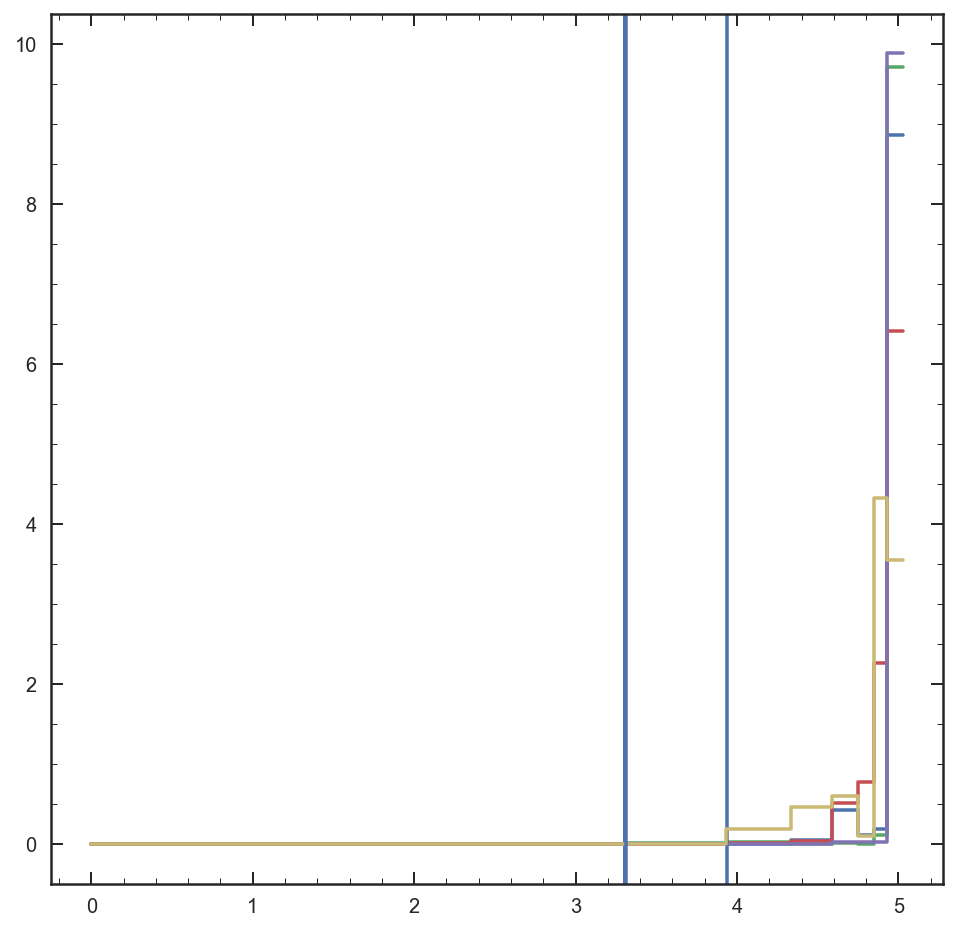

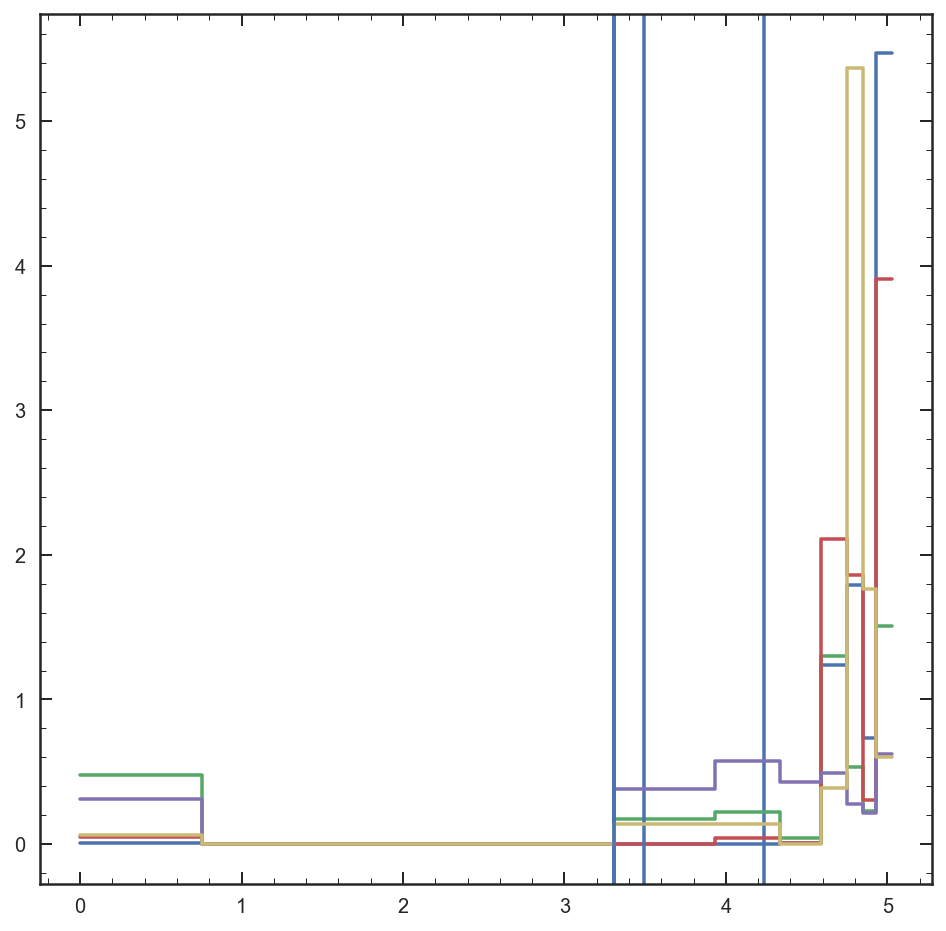

In [26]:
plt.figure(figsize=[8,8])
for i in range(5):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_no_prior{0}.npy'.format(i+1)).item()
    print(dres.logl[-1])
    bfZ, bft,bftau1, bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10,\
    bfz, bfd, bfm = dres.samples[-1]
    plt.step(np.append(0,LBT),[bftau1, bftau1,bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10])
    plt.axvline(bft)
    
print('------------------')
    
plt.figure(figsize=[8,8])
for i in range(5):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_delay_prior{0}.npy'.format(i+1)).item()
    print(dres.logl[-1])
    bfZ, bft,bftau1, bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10,\
    bfz, bfd, bfm = dres.samples[-1]
    plt.step(np.append(0,LBT),[bftau1, bftau1,bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10])
    plt.axvline(bft)
    
    
print('------------------')

plt.figure(figsize=[8,8])
for i in range(5):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_dirichlet_prior_a1_{0}.npy'.format(i+1)).item()
    print(dres.logl[-1])
    bfZ, bft,bftau1, bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10,\
    bfz, bfd, bfm = dres.samples[-1]
    plt.step(np.append(0,LBT),[bftau1, bftau1,bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10])
    plt.axvline(bft)
    
print('------------------')

plt.figure(figsize=[8,8])
for i in range(5):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_dirichlet_prior_a0.2_{0}.npy'.format(i+1)).item()
    print(dres.logl[-1])
    bfZ, bft,bftau1, bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10,\
    bfz, bfd, bfm = dres.samples[-1]
    plt.step(np.append(0,LBT),[bftau1, bftau1,bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10])
    plt.axvline(bft)
    

In [17]:
all_logl = []
for i in range(5):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_no_prior{0}.npy'.format(i+1)).item()
    all_logl.append(dres.logl[-1])
print(np.mean(all_logl))
    
print('------------------')
    
all_logl = []
for i in range(5):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_delay_prior{0}.npy'.format(i+1)).item()
    all_logl.append(dres.logl[-1])
print(np.mean(all_logl))
    
print('------------------')

all_logl = []
for i in range(5):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_dirichlet_prior_a1_{0}.npy'.format(i+1)).item()
    all_logl.append(dres.logl[-1])
print(np.mean(all_logl))
    
print('------------------')

all_logl = []
for i in range(5):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_dirichlet_prior_a0.2_{0}.npy'.format(i+1)).item()
    all_logl.append(dres.logl[-1])
print(np.mean(all_logl))
    

-249.50872587329224
------------------
-299.7039717310265
------------------
-221.0228157778059
------------------
-164.42550531341104


-249.73037924773948
-158.26197153042045
-275.0827630055003
-288.74816869354095
-165.24894109419273


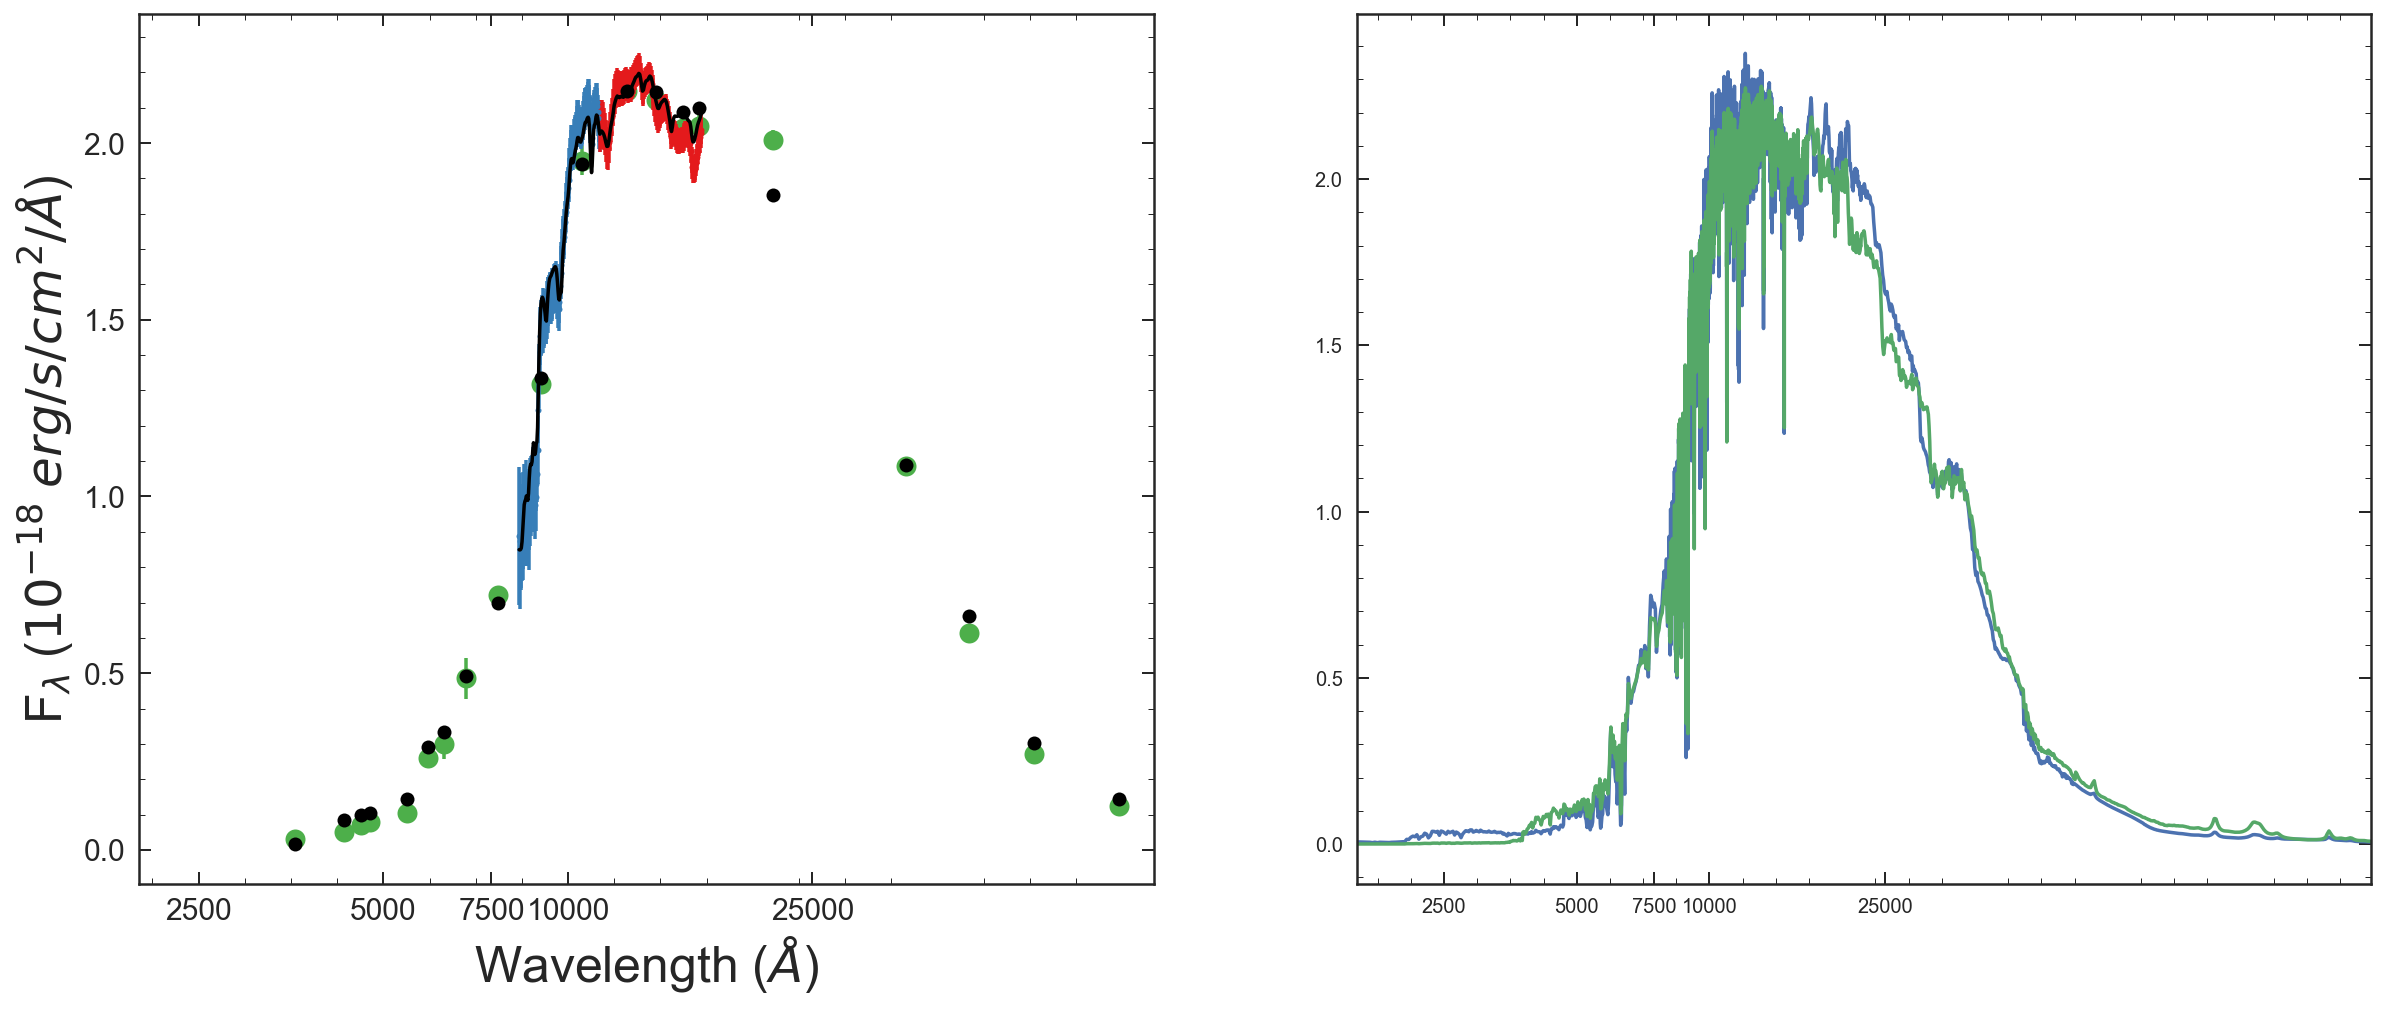

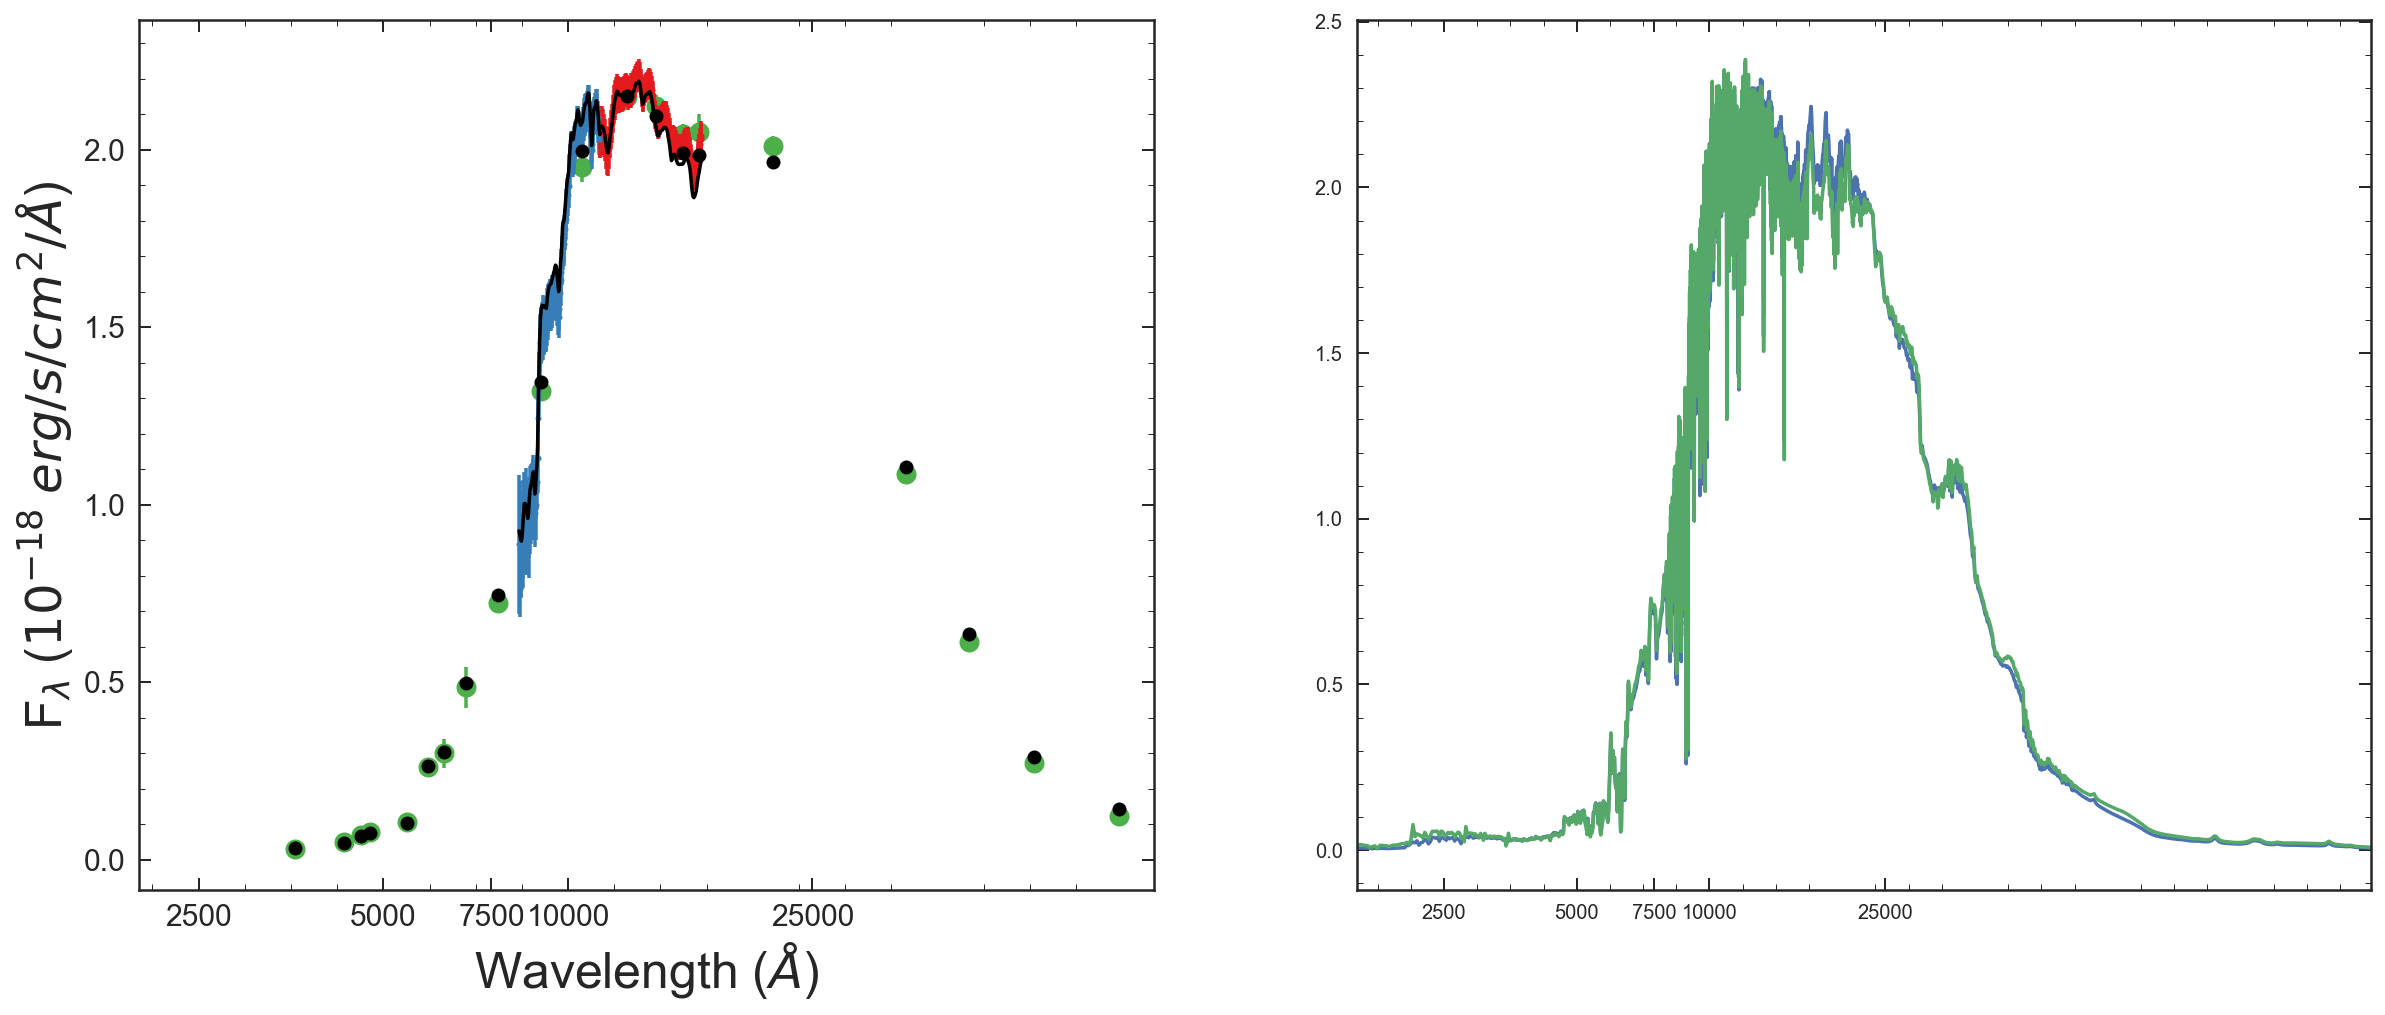

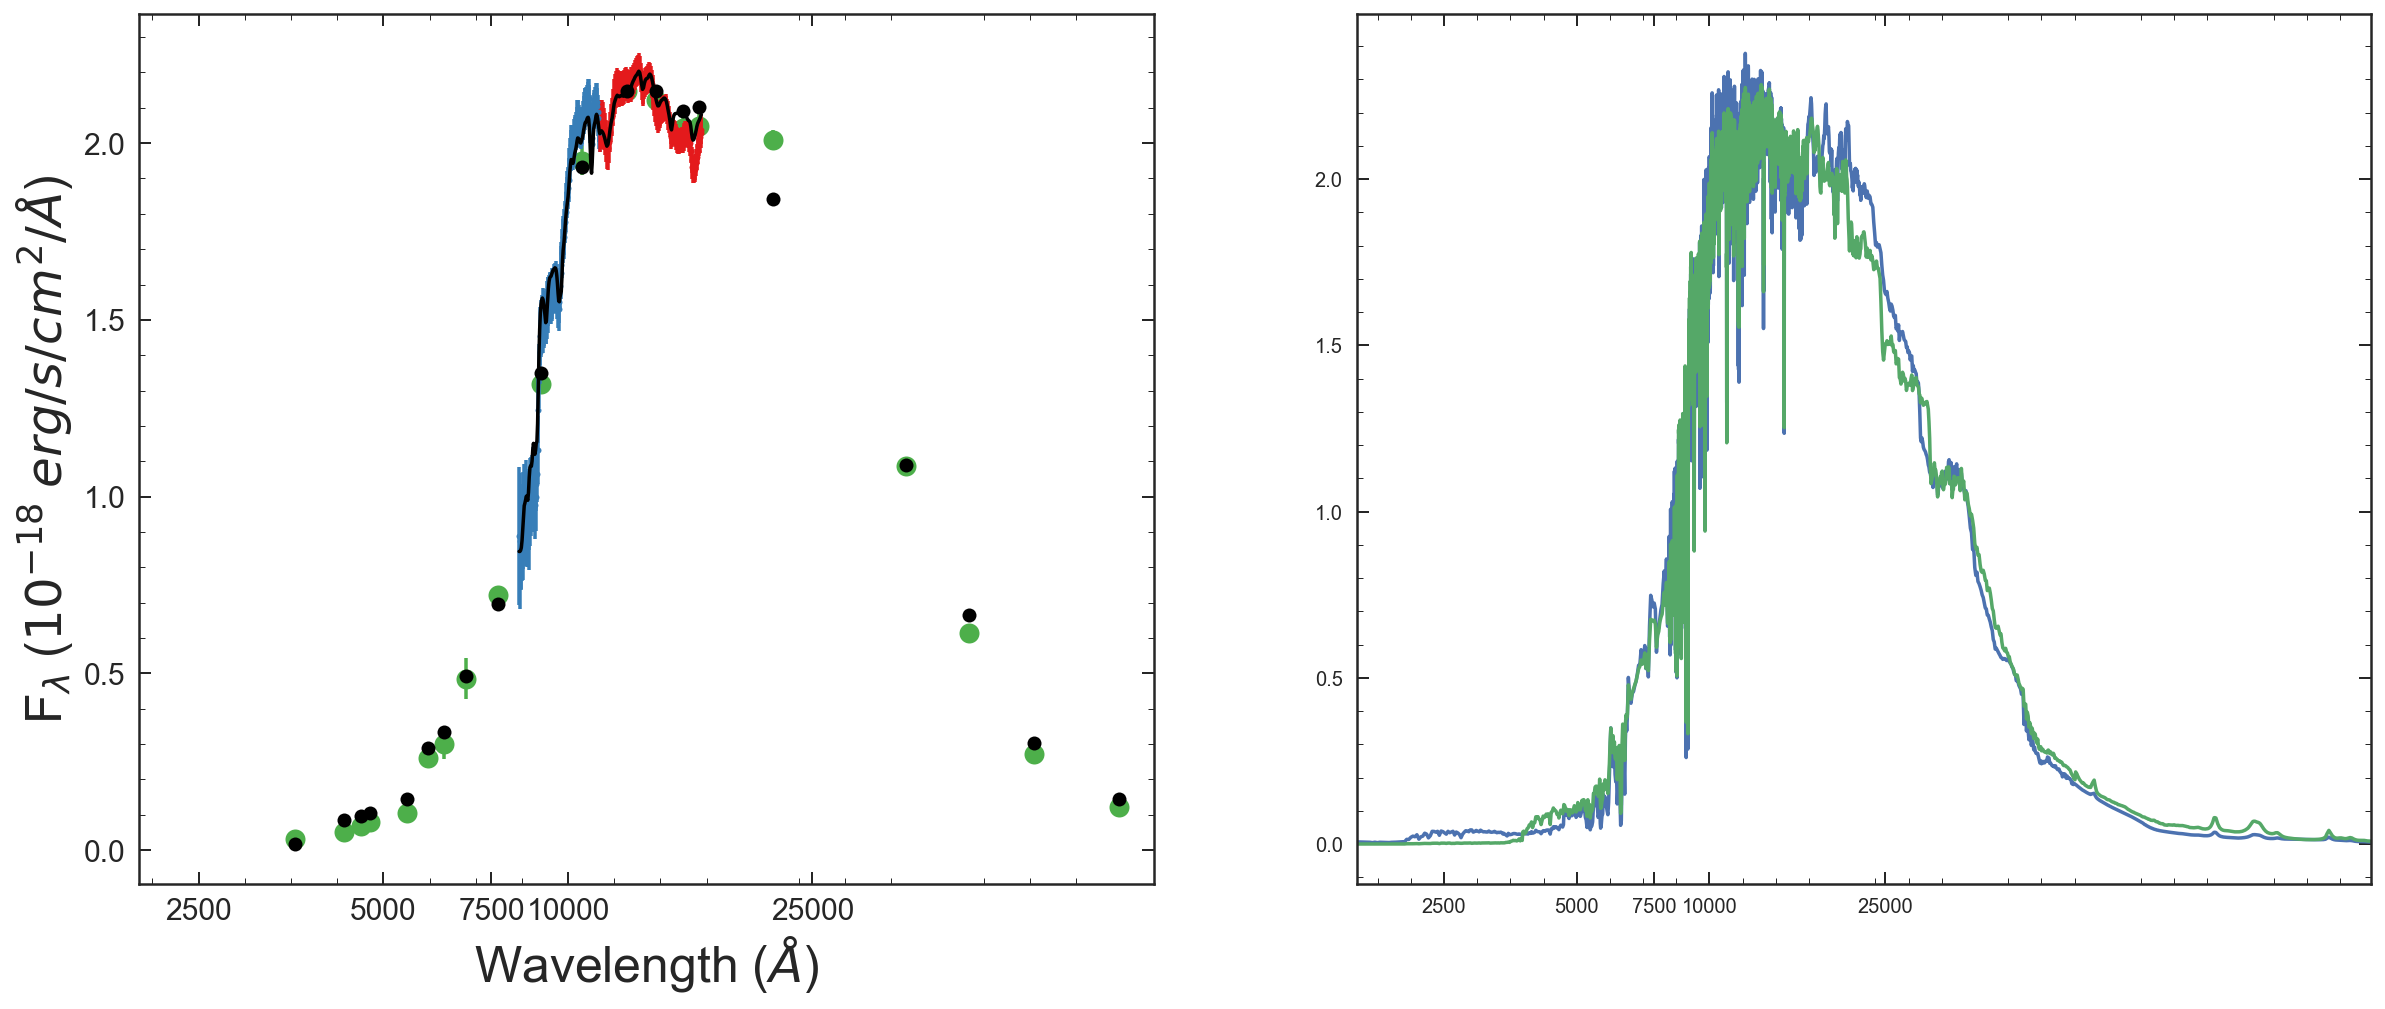

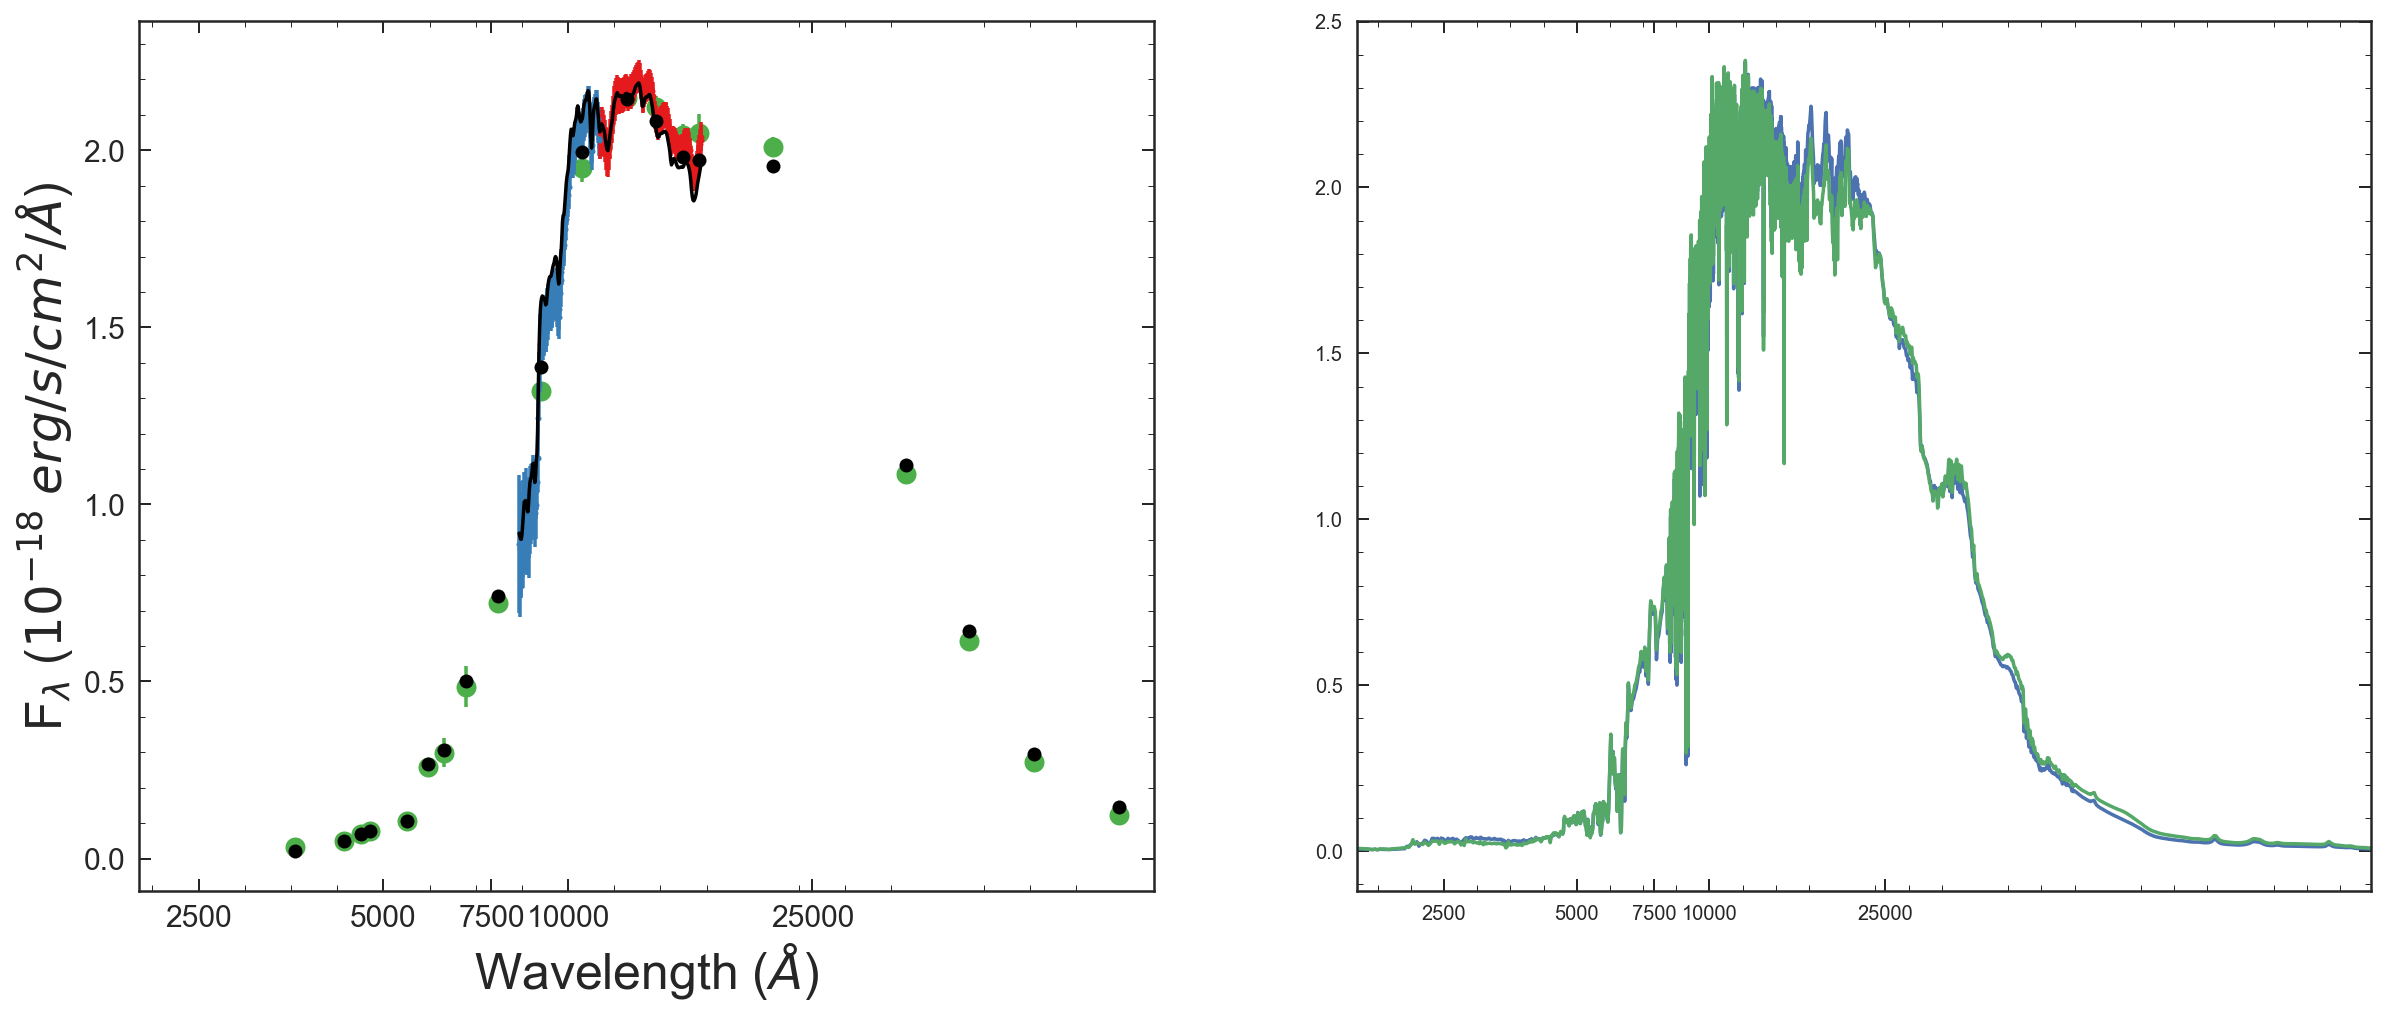

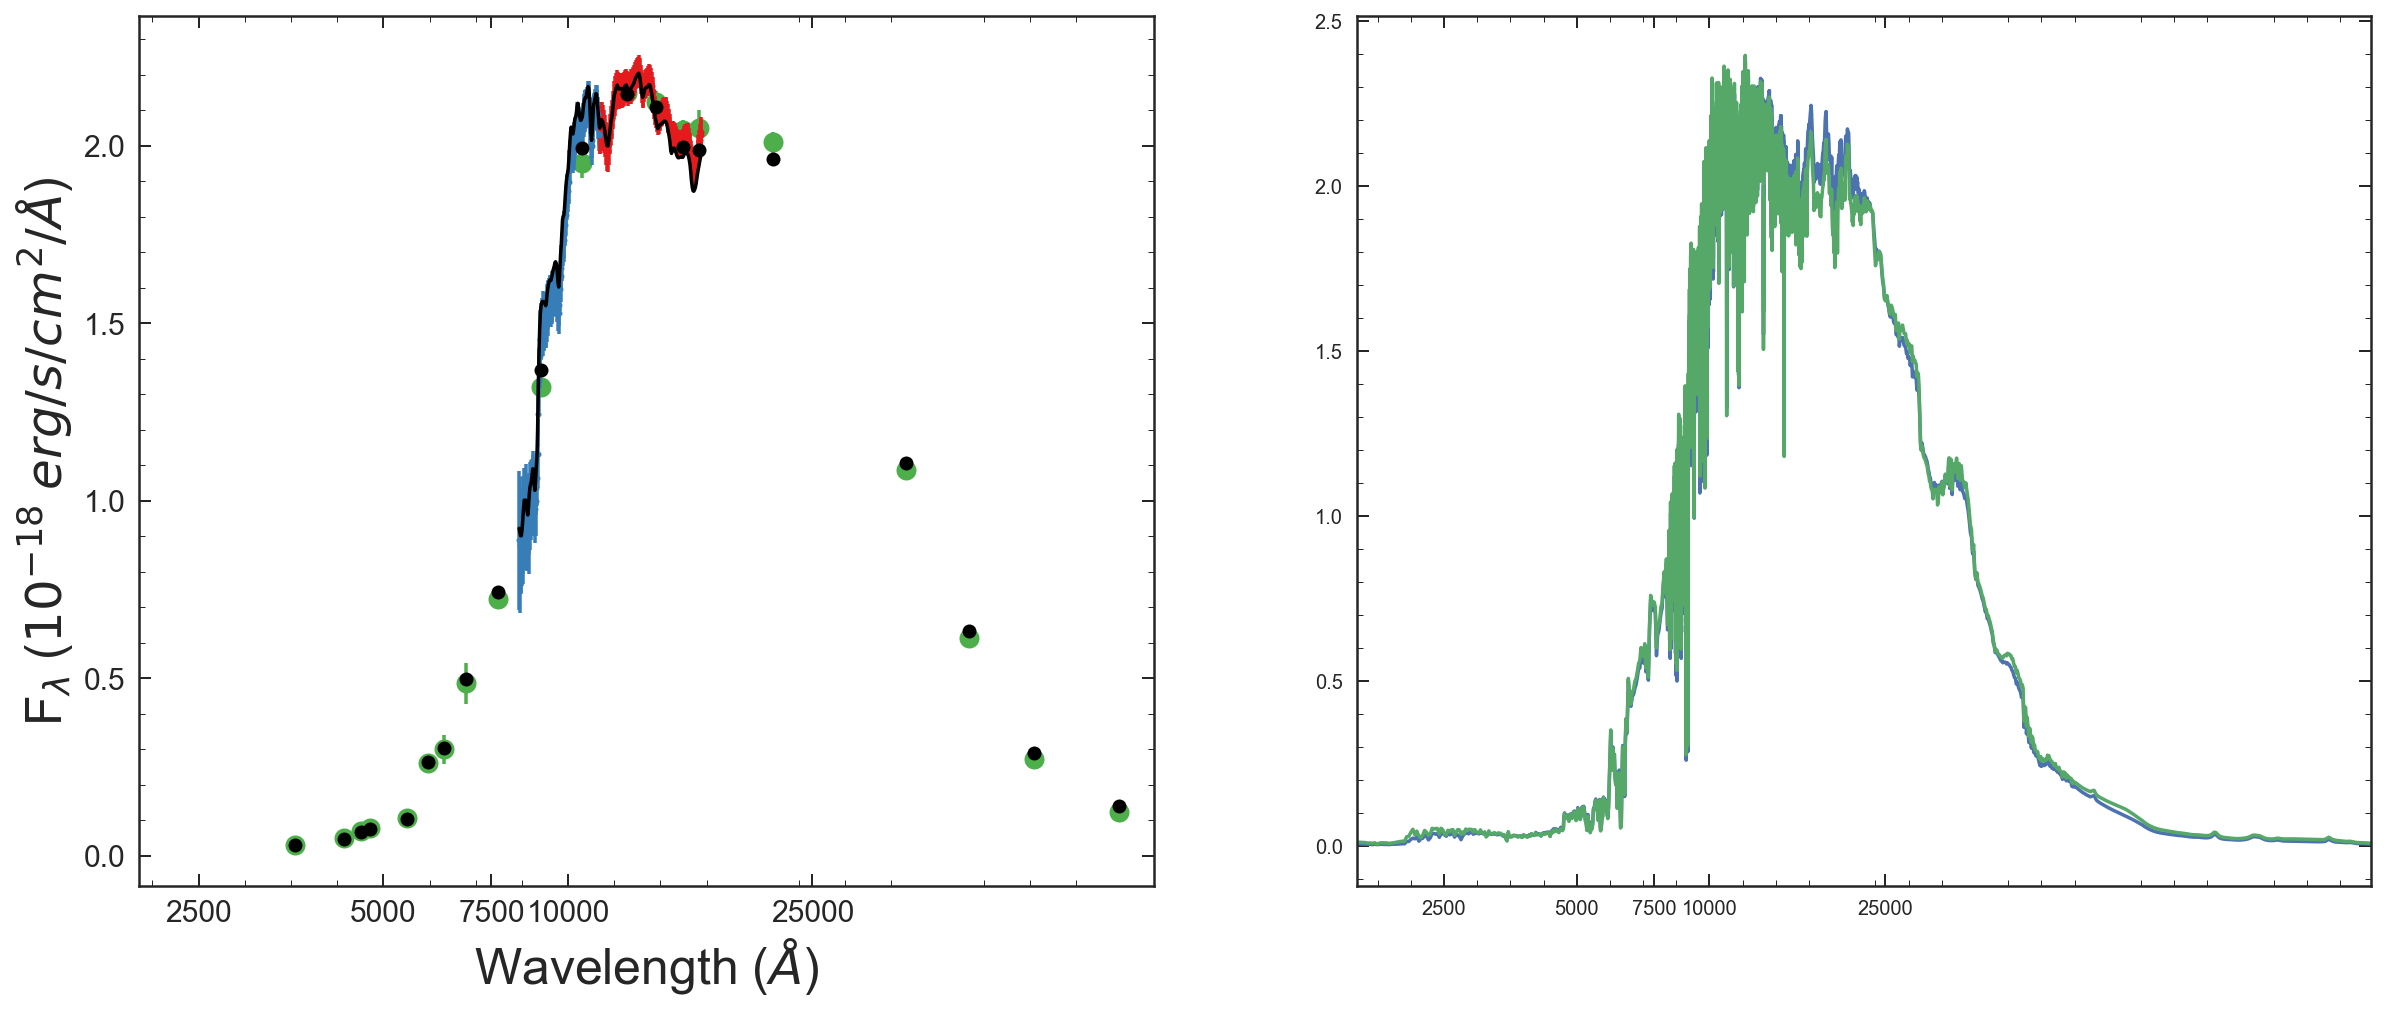

In [23]:
gs = GridSpec(1,2)

sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 3, dust_type = 1)

conv = 3.086E24 # Mpc to cm
lsol_to_fsol = 3.839E33 # change L_/odot to F_/odot

D_l = cosmo.luminosity_distance(1.25).value # in Mpc

d_mass_T = 10**11* lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)

for i in range(5):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_dirichlet_prior_a1_{0}.npy'.format(i+1)).item()

    bfZ, bft,bftau1, bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10,\
    bfz, bfd, bfm = dres.samples[-1]

    sp.params['dust2'] = bfd
    sp.params['dust1'] = bfd
    sp.params['logzsol'] = np.log10(bfZ)
    sp.set_tabular_sfh(LBT,np.array([bftau1, bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10]))

    wavedt, fluxdt = sp.get_spectrum(tage = bft, peraa = True)
    D_l = cosmo.luminosity_distance(bfz).value # in Mpc

    mass_T = (10**bfm / sp.stellar_mass) * lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)  

    sim2.Sim_all_premade(wavedt* (1+bfz), fluxdt * mass_T, scale=False)

    plt.figure(figsize = [20,8])
    plt.subplot(gs[0])

    plt.errorbar(np.log10(sim2.Bwv),sim2.SBfl*1E18,sim2.SBer*1E18,
                    linestyle='None', marker='o', markersize=3, color='#377eb8',zorder = 2, label = 'CLEAR G102')
    plt.errorbar(np.log10(sim2.Rwv),sim2.SRfl*1E18,sim2.SRer*1E18,
                    linestyle='None', marker='o', markersize=3, color='#e41a1c',zorder = 2, label = '3D-HST G141')
    plt.errorbar(np.log10(sim2.Pwv),sim2.SPflx*1E18,sim2.SPerr*1E18,
                                     linestyle='None', marker='o', markersize=10, color='#4daf4a',zorder = 1, label = '3D-HST Photometry')
    plt.plot(np.log10(sim2.Bwv), sim2.Bmfl*1E18, 'k', zorder=5)
    plt.plot(np.log10(sim2.Rwv), sim2.Rmfl*1E18, 'k', zorder=5)
    plt.plot(np.log10(sim2.Pwv), sim2.Pmfl*1E18, 'ko', zorder=5)

    plt.xlim(np.log10(2000), np.log10(90000))

    plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])

    plt.xlabel('Wavelength ($\AA$)', fontsize=25)
    plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=25)
    plt.tick_params(axis='both', which='major', labelsize=15)

    plt.subplot(gs[1])

    plt.plot(np.log10(wave2 * (1+specz)), flux2 * d_mass_T*1E18)
    plt.plot(np.log10(wavedt* (1+bfz)), fluxdt * mass_T * 1E18)
    plt.xlim(3.2,5.5)
    plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])

    print((sum(((sim2.SBfl - sim2.Bmfl) / sim2.SBer)**2) + sum(((sim2.SRfl - sim2.Rmfl) / sim2.SRer)**2) \
           + sum(((sim2.SPflx - sim2.Pmfl) / sim2.SPerr)**2)) * (-0.5))

In [46]:
# get lightweighted age

sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 3, sfh = 3, dust_type = 1)
sp.params['compute_light_ages'] = True

PLWA2 = []
LWA2 = []


for i in range(5):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_{0}.npy'.format(i+1)).item()
    
    lwa = []
    
    for ii in range(len(dres.samples)):
        bfZ1, bfZ2, bfZ3, bfZ4, bfZ5, bfZ6, bfZ7, bfZ8, bfZ9, bfZ10, bft,\
        bftau1, bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10,\
        bfz, bfd, bfm = dres.samples[-1]

        sp.params['dust2'] = bfd
        sp.params['dust1'] = bfd

        sp.set_tabular_sfh(LBT,np.array([bftau1, bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10]),
                          Z = np.array([bfZ1, bfZ2, bfZ3, bfZ4, bfZ5, bfZ6, bfZ7, bfZ8, bfZ9, bfZ10]) * 0.019)

        lwa.append(sp.get_mags(tage = bft, bands =['sdss_g'])[0])
    
    t,pt = Get_posterior(np.array(lwa), dres.logwt,dres.logz)
    LWA2.append(t)
    PLWA2.append(pt)
       
sp.params['compute_light_ages'] = False

In [47]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 4, tau=0.1, dust_type = 1)
sp.params['compute_light_ages'] = True

sp.params['dust2'] =0.2
sp.params['dust1'] =0.2
sp.params['tau'] =0.3
sp.params['logzsol'] = np.log10(0.8)

lwa2 = sp.get_mags(tage = 3.5, bands =['sdss_g'])
       
sp.params['compute_light_ages'] = False

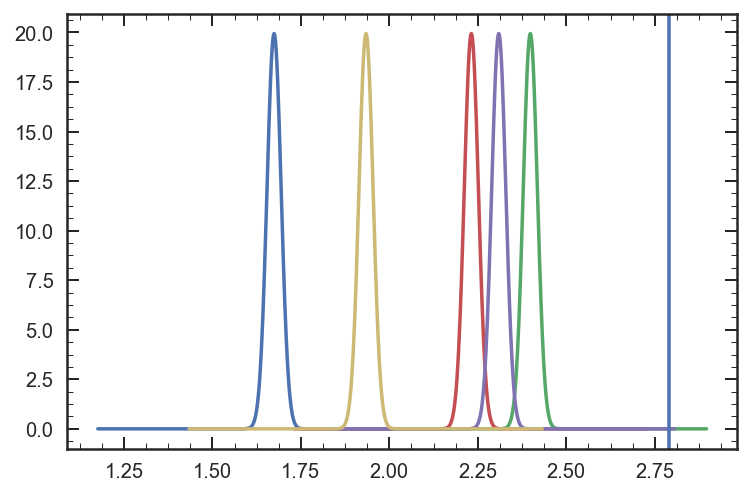

In [48]:
for i in range(5):
    plt.plot(LWA2[i], PLWA2[i])
plt.axvline(lwa2)

In [1]:
from spec_exam import Gen_spec
import numpy as np
from glob import glob
import pandas as pd
import os
import sys
import fsps
import dynesty
from scipy.interpolate import interp1d, RegularGridInterpolator
from sim_engine import forward_model_grism, Salmon
from spec_id import Scale_model
from spec_tools import Oldest_galaxy
from astropy.cosmology import Planck13 as cosmo
from multiprocessing import Pool

hpath = os.environ['HOME'] + '/'

if hpath == '/home/vestrada78840/':
    data_path = '/fdata/scratch/vestrada78840/data/'
    model_path ='/fdata/scratch/vestrada78840/fsps_spec/'
    chi_path = '/fdata/scratch/vestrada78840/chidat/'
    spec_path = '/fdata/scratch/vestrada78840/stack_specs/'
    beam_path = '/fdata/scratch/vestrada78840/beams/'
    template_path = '/fdata/scratch/vestrada78840/data/'
    out_path = '/home/vestrada78840/chidat/'
    phot_path = '/fdata/scratch/vestrada78840/phot/'

else:
    data_path = '../data/'
    model_path = hpath + 'fsps_models_for_fit/fsps_spec/'
    chi_path = '../chidat/'
    spec_path = '../spec_files/'
    beam_path = '../beams/'
    template_path = '../templates/'
    out_path = '../data/posteriors/'
    phot_path = '../phot/'
    
specz = 1.25
    
sim1 = Gen_spec('GND', 21156, 1.25257,
               g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = True,
            phot_errterm = 0.0, decontam = False) 

sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 3, sfh = 3, dust_type = 1)
sp.params['dust2'] =0.2
sp.params['dust1'] =0.2

tab_sfh = np.array([0.7, 0.8, 0.5, 0.01, 0.01, 0.001, 0.00001, 0.0002, 0.002, 0.0001])
tab_Z = np.array([0.2, 0.8, 1.0, 1.0, 0.8, 1.1, 0.7, 0.8, 0.8, 0.8])*0.019

def Time_bins(agelim, bins):
    u = 0.0
    lbt = []
    for i in range(bins):
        u+=0.1 * i
        lbt.append(np.round(u,1))
    
    return np.array(agelim  - lbt / np.round(u + 0.1 * (i+1),1) * agelim)[::-1]

LBT = Time_bins(Oldest_galaxy(1.25),10)

sp.set_tabular_sfh(LBT,tab_sfh,
                   Z = tab_Z )

wave1, flux1 = sp.get_spectrum(tage = 3.5, peraa = True)

mass_perc1 = sp.stellar_mass
 
D_l = cosmo.luminosity_distance(specz).value # in Mpc
conv = 3.086E24
lsol_to_fsol = 3.839E33

mass_transform = (10**11 / mass_perc1) * lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)
    
sim1.Make_sim(wave1, flux1 * mass_transform, specz)
   
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 4, tau=0.1, dust_type = 1)

############
###priors###
agelim = Oldest_galaxy(specz)

def delay_prior(u):
    m = (0.03 * u[0] + 0.001) / 0.019
    a = (agelim - 0.01)* u[1] + 0.01
    t = (1.5 - 0.001)*u[2] + 0.001  
    z = specz + 0.002*(2*u[3] - 1)
    d = 1*u[4]
    lm = 11.0 + 1.25*(2*u[5] - 1)

    return [m, a, t, z, d, lm]

############
#likelihood#
def Gather_grism_sim_data(spec):
    wvs = []
    flxs = []
    errs = []
    beams = []
    trans = []
    
    if spec.g102:
        wvs.append(spec.Bwv)
        flxs.append(spec.SBfl)
        errs.append(spec.SBer)
        beams.append(spec.Bbeam)
        trans.append(spec.Btrans)
    
    if spec.g141:
        wvs.append(spec.Rwv)
        flxs.append(spec.SRfl)
        errs.append(spec.SRer)
        beams.append(spec.Rbeam)
        trans.append(spec.Rtrans)

    return np.array([wvs, flxs, errs, beams, trans])

def forward_model_all_beams(beams, trans, in_wv, model_wave, model_flux):
    FL = np.zeros([len(beams),len(in_wv)])

    for i in range(len(beams)):
        mwv, mflx = forward_model_grism(beams[i], model_wave, model_flux)
        FL[i] = interp1d(mwv, mflx)(in_wv)
        FL[i] /= trans[i]

    return np.mean(FL.T,axis=1)

def Full_forward_model(spec, wave, flux, specz):
    Gmfl = []
    
    for i in range(len(wvs1)):
        Gmfl.append(forward_model_all_beams(beams1[i], trans1[i], wvs1[i], wave * (1 + specz), flux))

    Pmfl = spec.Sim_phot_mult(wave * (1 + specz),flux)

    return np.array(Gmfl), Pmfl


def Full_fit(spec, Gmfl, Pmfl):
    Gchi = 0
    
    for i in range(len(wvs1)):
#         scale = Scale_model(flxs1[i], errs1[i], Gmfl[i])
        Gchi = Gchi + np.sum( ((flxs1[i] - Gmfl[i]) / errs1[i])**2 )
    
    Pchi = np.sum((((spec.SPflx - Pmfl) / spec.SPerr)**2))
    
    return Gchi, Pchi

wvs1, flxs1, errs1, beams1, trans1 = Gather_grism_sim_data(sim1)

conv = 3.086E24 # Mpc to cm
lsol_to_fsol = 3.839E33 # change L_/odot to F_/odot

def delay_L(X):
    m, a, t, z, d, lm = X
    
    sp.params['logzsol'] = np.log10( m )
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    sp.params['tau'] = t

    wave, flux = sp.get_spectrum(tage = a, peraa = True)
    
    D_l = cosmo.luminosity_distance(z).value # in Mpc

    mass_transform = (10**lm * lsol_to_fsol) / (4 * np.pi * (D_l*conv)**2)
    
    Gmfl, Pmfl = Full_forward_model(sim1, wave, flux * mass_transform, z)
    
    Gchi, Pchi = Full_fit(sim1, Gmfl, Pmfl)
                  
    return -0.5 * (Gchi + Pchi)

############
####run#####
t_dsampler = dynesty.NestedSampler(delay_L, delay_prior, ndim = 6, sample = 'rwalk', bound = 'balls',
                                  queue_size = 8, pool = Pool(processes=8)) 
t_dsampler.run_nested(print_progress=True)

dres = t_dsampler.results

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
iter: 12488+500 | bound: 672 | nc: 1 | ncall: 287123 | eff(%):  4.523 | loglstar:   -inf < -123.554 <    inf | logz: -147.944 +/-  0.222 | dlogz:  0.001 >  0.509            /Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampler.py:220: RuntimeWarning: invalid value encountered in sqrt
  ('logzerr', np.sqrt(np.array(self.saved_logzvar))),


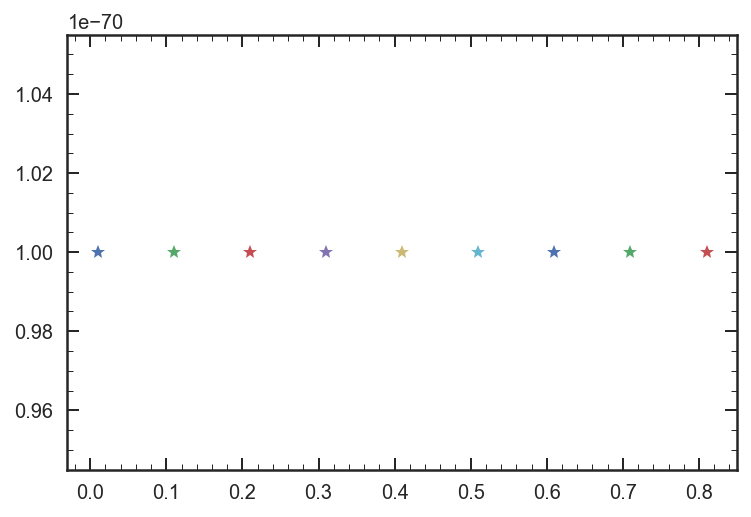

In [52]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 3, sfh = 3, dust_type = 1)
sp.params['compute_light_ages'] = True

sp.params['dust2'] = 0.2
sp.params['dust1'] = 0.2

sp.set_tabular_sfh(LBT,np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
                  Z = np.array([1,1,1,1,1,1,1,1,1,1]) * 0.019)

t= np.arange(0.01, LBT[0], 0.1)

for i in t:
    plt.plot(i,sp.get_mags(tage = i, bands =['sdss_g'])[0],'*')
    
       
sp.params['compute_light_ages'] = False

In [30]:
lages = [0,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9,10]

lagebins = []

for i in range(len(lages)-1):
    lagebins.append([lages[i], lages[i+1]])

upd_lagebins = zred_to_agebins(zred=0.8, agebins=lagebins)

print((10**upd_lagebins.T[1][::-1][0] - 10**upd_lagebins.T[0][::-1])*1E-9)

[1.02474441 2.00793365 2.8246548  3.5030933  4.06666239 4.53481111
 4.92369552 5.2467362  5.57270398 6.83162939]


In [31]:
upd_lagebins

array([[0.        , 9.1       ],
       [9.1       , 9.2       ],
       [9.2       , 9.28056332],
       [9.28056332, 9.36112664],
       [9.36112664, 9.44168995],
       [9.44168995, 9.52225327],
       [9.52225327, 9.60281659],
       [9.60281659, 9.68337991],
       [9.68337991, 9.76394322],
       [9.76394322, 9.8345243 ]])